# This is to develope the assignment per tile related routines
Shadab Alam

In [1]:
using Pkg

In [2]:
include("src/MockFBA.jl")
import MockFBA

┌ Info: Precompiling MockFBA [8f5b17de-7982-4597-b420-356a140355ec]
└ @ Base loading.jl:1423
┌ Warning: Package MockFBA does not have FITSIO in its dependencies:
│ - If you have MockFBA checked out for development and have
│   added FITSIO as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with MockFBA
└ Loading FITSIO into MockFBA from project dependency, future warnings for MockFBA are suppressed.


LoadError: importing MockFBA into Main conflicts with an existing identifier

In [315]:
Pkg.add("CodecLz4")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Lz4_jll ── v1.9.3+0
   Installed CodecLz4 ─ v0.4.0
┌ Warning: The active manifest file at `/Users/shadab/Documents/Projects/MockFBA/Manifest.toml` has an old format that is being maintained.
│ To update to the new format run `Pkg.upgrade_manifest()` which will upgrade the format without re-resolving.
└ @ Pkg.Types /private/tmp/julia-20211223-81055-17amu57/julia-1.7.1/usr/share/julia/stdlib/v1.7/Pkg/src/manifest.jl:287
    Updating `~/Documents/Projects/MockFBA/Project.toml`
  [5ba52731] + CodecLz4 v0.4.0
    Updating `~/Documents/Projects/MockFBA/Manifest.toml`
  [5ba52731] + CodecLz4 v0.4.0
  [5ced341a] + Lz4_jll v1.9.3+0
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /Users/shadab/Documents/Projects/MockFBA/Manifest.toml:0
Precompiling project...
  ✓ Lz4_jll
  ✓ Co

In [3]:
using Printf
using JLD2
using Plots
using DelimitedFiles
using DataInterpolations
using StaticArrays
using FITSIO
using YAML
using CSV
using BenchmarkTools
using LoopVectorization
using Bits
using DataFrames
using CodecLz4

In [4]:
using MockFBA

LoadError: importing MockFBA into Main conflicts with an existing identifier

# Dev Plan
    * Load a tile
    * Transform to the xy- plane including focal plane curvature using focal plane data
    * load the positioner hardware info
    * Generate zones in x-y with scale of largest positioner reach+ epsilon for possible collision
    * Choose a position and run full assignment
    * Run this over all positioner
    * Divide the assignment to the JLD2 file structure (but keep in memory)
    * Run multiple tile in parallel
    * Process pass-wise tile
    

In [5]:
#To use the function in mockFBA directly here
embed_sphere=MockFBA.embed_sphere

function deg2rad(rdeg)
    return pi*rdeg/180
end

deg2rad (generic function with 1 method)

In [6]:
""" Adapted from desimodel.io 
https://github.com/desihub/desimodel/blob/d5f7f871873c547892a40ece30890b8610f53768/py/desimodel/io.py#L336
Loads platescale.txt.
    Returns
    -------
    :class:`~numpy.recarray`\n
        The data table read from the file.
    Notes
    -----
    The returned object has these columns:
    radius
        Radius from center of focal plane [mm].
    theta
        Radial angle that has a centroid at this radius [deg].
    radial_platescale
        Meridional (radial) plate scale [um/arcsec].
    az_platescale:
        Sagittal (azimuthal) plate scale [um/arcsec].
    arclength:
        Unknown description.

"""
function load_platescale(focalplane_dir)

    plate_scale_file="$(focalplane_dir)platescale.txt"
    plate_scale_columns=Dict("radius"=>1 ,"theta"=>2 ,"radial_platescale"=>7,
                   "az_platescale"=>8)
    
    rzs_file="$(focalplane_dir)rzsn.txt"
    rzs_column=Dict("R"=>1 ,"Z"=>2, "S"=>3, "N"=>4)

    #load and setup the plate scale disctionary
    platescale_dic=Dict()
    tab1=readdlm(plate_scale_file, Float64,comments=true)
    for col in keys(plate_scale_columns)
        platescale_dic[col]=tab1[:,plate_scale_columns[col]]
    end
    
    # One of the header column is not commented hence skipstart
    tab1=readdlm(rzs_file, Float64,comments=true,skipstart=8)
    
    #This function take yas first input and then x as second!!
    #https://htmlpreview.github.io/?https://github.com/PumasAI/DataInterpolations.jl/blob/v2.0.0/example/DataInterpolations.html
    rz_itp = QuadraticInterpolation(tab1[:,rzs_column["Z"]],tab1[:,rzs_column["R"]])
    
    platescale_dic["arclength"]=rz_itp.(platescale_dic["radius"])

    return platescale_dic
end

"""Adapted from desimodel.io
Returns an array of radii in mm given an array of radii in degrees using the platescale data
    relative to the center of the focal plane as (0,0). Supports scalar and vector inputs.\n
    Parameters
    ----------
    theta : :class:`float` or array-like
        An array that represents the angle from the center of the focal plane.
    Returns
    -------
    :class:`float` or array-like
        Radii in mm.
"""
function get_radius_mm(platescale::Dict{Any,Any},theta::Vector)
    
    #platescale = load_platescale(focalplane_dir)
    
    # Uses a quadratic one-dimensional interpolation to approximate the radius in degrees versus radius in mm
    #This function take yas first input and then x as second!!
    #https://htmlpreview.github.io/?https://github.com/PumasAI/DataInterpolations.jl/blob/v2.0.0/example/DataInterpolations.html
    rz_itp = QuadraticInterpolation(platescale["radius"],platescale["theta"])
    
    radius = rz_itp.(theta)
    
    #This to plot the interpolation for testing
    #scatter(platescale["theta"], platescale["radius"], label="input data")
    #plot!(rz_itp) 
    #plot!(theta,radius) |> display
    
    return radius
end

function get_radius_mm(focalplane_dir::String,theta)
    platescale = load_platescale(focalplane_dir)
    radius=get_radius_mm(platescale,theta)
    return radius
end

get_radius_mm (generic function with 2 methods)

In [260]:
    

""" Adapted from desimodel.focalplane.geometry \n
Returns arrays of the x, y positions of given celestial objects
    on the focal plane given an arbitrary telescope pointing in RA and Dec and
    arrays of the `ra` and `dec` of celestial objects in the sky.\n
    Parameters
    ----------
    telra : :class:`float`
        The telescope's RA pointing in degrees.
    teldec : :class:`float`
        The telescope's Dec pointing in degrees.
    ra : array-like
        An array of RA values for locations in the sky.
    dec : array-like
        An array of Dec values for locations in the sky.
    Returns
    -------
    tuple
        The x, y positions corrsponding to `ra`, `dec`.
    Notes
    -----
    Implements the Haversine formula.
"""
function xyz_unit_2_xy_focalplane(telra, teldec, x_unit,y_unit,z_unit,platescale::Dict{Any,Any})
    # Inclination is 90 degrees minus the declination in degrees
    nobj=size(x_unit,1)
    
    telra_rad=deg2rad(telra)
    teldec_rad=deg2rad(teldec)

    # Clockwise rotation around the z-axis by the right ascension of the tile center
    #Note that this uses column major order which mean
    #the first three values are in first column and not first row
    rarotate = SMatrix{3,3}(cos(telra_rad),-sin(telra_rad),0,
                            sin(telra_rad),cos(telra_rad),0,
                            0,0,1)
    

    # Counter-Clockwise rotation around y axis by declination of the tile center
    decrotate = SMatrix{3,3}(cos(teldec_rad),0,-sin(teldec_rad),
                            0,1,0,
                            sin(teldec_rad),0,cos(teldec_rad))
        

    dec_ra_rotate=decrotate*rarotate
    

    x_new = dec_ra_rotate[1,1].*x_unit .+ dec_ra_rotate[1,2].*y_unit .+ dec_ra_rotate[1,3].*z_unit
    y_new = dec_ra_rotate[2,1].*x_unit .+ dec_ra_rotate[2,2].*y_unit .+ dec_ra_rotate[2,3].*z_unit
    z_new = dec_ra_rotate[3,1].*x_unit .+ dec_ra_rotate[3,2].*y_unit .+ dec_ra_rotate[3,3].*z_unit

    newteldec = 0
    newtelra = 0
    
    ra_rad = atan.(y_new, x_new)
    
    dec_rad = (pi / 2) .- acos.(z_new) #assuming x,y,z on unit sphere so norm is 1
    
    radius_rad= (sin.(0.5 .* dec_rad).^2) .+ ((sin.(0.5 .* ra_rad).^2).*cos.(dec_rad))
    @. radius_rad = 2.0 .* asin.(sqrt.(radius_rad))
    
    #Finally convert this in degree but keep the variable name same for memory
    radius_rad .= radius_rad .* (180/pi)

    q_rad = atan.(z_new, -y_new)

    radius_mm = get_radius_mm(platescale,radius_rad)

    x_focalplane =@. radius_mm * cos(q_rad)
    y_focalplane =@. radius_mm * sin(q_rad)

    return x_focalplane, y_focalplane
end

function radec2xy_focalplane(telra, teldec, ra, dec,platescale::Dict{Any,Any})
    
    #Convert dec to inclination angle in radian
    x_unit,y_unit,z_unit = embed_sphere(ra,dec)
    
    x_focalplane, y_focalplane= xyz_unit_2_xy_focalplane(telra, teldec, x_unit,y_unit,z_unit,platescale)
    return x_focalplane, y_focalplane
end

"""Generate the bounding grid of focal plane
"""
struct focal_plane_Bound
    xmin::Float64
    xmax::Float64
    ymin::Float64
    ymax::Float64
    dx_zone::Float64
    dy_zone::Float64
    nx::Int32
    ny::Int32
end

function get_bound_focal_plane(xfocal,yfocal,grid_scale;pad=0.2)
    xlim=[minimum(xfocal)-pad,maximum(xfocal)+pad]
    ylim=[minimum(yfocal)-pad,maximum(yfocal)+pad]
    
    
    nx=floor(Int,(xlim[2]-xlim[1])/grid_scale)
    ny=floor(Int,(ylim[2]-ylim[1])/grid_scale)
    
    dx_zone=(xlim[2]-xlim[1])/(nx-1)
    dy_zone=(ylim[2]-ylim[1])/(ny-1)
    
    fp_bound=focal_plane_Bound(xlim[1],xlim[2],ylim[1],ylim[2],dx_zone,dy_zone,nx,ny)
    
    return fp_bound
end

function Assign_xy_zone(xfocal,yfocal,fp_bound)
    nobj=size(xfocal,1)
    
    zone_x=zeros(Int16,nobj)
    zone_y=zeros(Int16,nobj)
    
    @. zone_x = floor(Int16,(xfocal-fp_bound.xmin)/fp_bound.dx_zone)
    @. zone_y = floor(Int16,(yfocal-fp_bound.ymin)/fp_bound.dy_zone)
    
    
    if(false)#To make some plots for visualization
        plot([0],[0],seriestype=:scatter,color=:green)
        for ii in 0:fp_bound.nx-1
            for jj in 0:fp_bound.ny-1
                indsel= findall((zone_x .== ii) .& (zone_y .== jj))
                if(size(indsel,1)>0)
                    println(ii,' ',jj,' ',size(indsel,1))
                    plot!(xfocal[indsel],yfocal[indsel],seriestype=:scatter,color=:auto)
                end
            end
        end
                    
        plot!([0],[0],seriestype=:scatter,color=:blue) |> display
    end
    
    return zone_x,zone_y
end

"""
Loads the status of focal plane based on given date
look for following file with appropriate dates
    desi-exclusion_2019-09-16T00:00:00.yaml  
    desi-focalplane_2019-09-16T00:00:00.ecsv 
    desi-state_2019-09-16T00:00:00.ecsv
"""
function load_focal_plane_hardware(config;date="2019-09-16T00:00:00")
    
    harware_fp=Dict()
    
    file_fp="$(focalplane_dir)desi-focalplane_$(date).ecsv"
    df=CSV.read(file_fp, DataFrame;delim=" ",comment="#",header=1)
    
    
    return df

end

"""Load the focal plane file from jld2 format
if jld2 format doesn't exists then load the ascii version
and convert it to jld2 seperating into two group
one called base consisting of column we should need for fba
and other called extra contain everything else
It only loads the base part on any future call if jld2 file exists
"""
function load_hw_focalplane_file(config;date="2019-09-16T00:00:00")

    base_cols=["OFFSET_X","OFFSET_Y","LOCATION","MIN_T","MAX_T","MIN_P","MAX_P",
                    "OFFSET_T","OFFSET_P","LENGTH_R1","LENGTH_R2","DEVICE_TYPE"]
    
    fp_jld2="$(config["focalplane_dir_jld2"])desi-focalplane_$(date).jld2"
    

    if(isfile(fp_jld2))
        #fp_base=load(fp_jld2,"base")
        fp_base=read_columns_jld2(fp_jld2,base_cols)
    else
        file_fp="$(config["focalplane_dir"])desi-focalplane_$(date).ecsv"
        if(! isfile(file_fp))
            warn("File no Found $(file_fp)")
        else#Load the csv file convert to jld2 file
            df=CSV.read(file_fp, DataFrame;delim=" ",comment="#",header=1)
            
            DataFrame_TO_JLD2(df,fp_jld2,base_cols)
            fp_base=read_columns_jld2(fp_jld2,base_cols)
        end
    end
    return fp_base
end

function load_hw_state_file(config;date="2019-09-16T00:00:00")

    base_cols=["LOCATION", "STATE", "EXCLUSION"]
    st_jld2="$(config["focalplane_dir_jld2"])desi-state_$(date).jld2"
    

    if(isfile(st_jld2))
        st_base=read_columns_jld2(st_jld2,base_cols)
    else
        file_st="$(config["focalplane_dir"])desi-state_$(date).ecsv"
        if(! isfile(file_st))
            warn("File no Found $(file_st)")
        else#Load the csv file convert to jld2 file
            df=CSV.read(file_st, DataFrame;delim=" ",comment="#",header=1)
            #Write the JLD2 file
            DataFrame_TO_JLD2(df,st_jld2,base_cols)
            #st_base=load(st_jld2,"base")
            st_base=read_columns_jld2(st_jld2,base_cols)
        end
    end
    return st_base
end


"""transforms the nested ditionary loaded from yaml to flat dictionary
"""
function transform_dictionary_flatJLD(jldfile,dicin)
    jldopen(jldfile,"a+",compress=LZ4FrameCompressor()) do file
        for tkey in keys(dicin)
            for pkey in keys(dicin[tkey])
                for lkey in keys(dicin[tkey][pkey])
                    nel=length(desi_exc[tkey][pkey][lkey])
                    if(nel==0)
                        continue
                    elseif(nel>1)
                        @warn(" Found more than one element $(tkey) > $(pkey) > $(lkey) : $(nel)\n
                            Ignoring elements after the first one please chekc the raw file for errors")
                    end
                    
                    tarr=desi_exc[tkey][pkey][lkey][1]
                    nseg=length(tarr)
                    if(lkey=="circles")
                        out_arr=[tarr[1][1],tarr[1][2],tarr[2][1]]
                    else
                        out_arr=zeros(nseg,2)
                        for ii in 1:nseg
                            out_arr[ii,:]=tarr[ii]
                        end
                    end
                    write(file,"$(tkey)-$(pkey)-$(lkey)",out_arr,compress=true)
                end
            end
        end
    end
end

"""load the flat dictionary of array and converts it into a StaticArray
"""
function load_exclusion(jldfile)
    tdic=load(jldfile)

    for tkey in keys(tdic)
        nsize=size(tdic[tkey])
        if(length(nsize)==2)
            tdic[tkey]=SMatrix{nsize[1],nsize[2],Float32}(tdic[tkey])
        else
            tdic[tkey]=SVector{nsize[1],Float32}(tdic[tkey])
        end
        #println(tkey,nsize[1])
    end
    return tdic
end


function load_hw_exclusion_file(config;date="2019-09-16T00:00:00")

    exc_jld2="$(config["focalplane_dir_jld2"])desi-exclusion_$(date).jld2"
    
    
    if(isfile(exc_jld2))
        exc=load_exclusion(exc_jld2)
    else
        file_exc="$(config["focalplane_dir"])desi-exclusion_$(date).yaml"
        #loads the yaml file
        desi_exc=YAML.load_file(file_exc)
        #flattens the ditionary, convert to array and compress and save
        transform_dictionary_flatJLD(exc_jld2,desi_exc)
        
        #finally load the new format and covert them to static arrays for speed
        exc=load_exclusion(exc_jld2)
    end
    return exc
end



function DataFrame_TO_JLD2(df,jldfile,base_cols;compress=false)
    #save the base property
    #tdic_base=Dict()
    #tdic_extra=Dict()
    
    jldopen(jldfile, "a+",compress=LZ4FrameCompressor()) do file
        for col in names(df)
            if(col in base_cols)
                #tdic_base[col]=df[!,col]
                write(file,"$(col)",df[!,col],compress=true)
            else
                #tdic_extra[col]=df[!,col]
                write(file,"$(col)",df[!,col],compress=true)
            end
        end

    
        #delete if needed or just write
        #write(file,"extra",tdic_extra,compress=compress)
    end
            
    println("saved base and extra properties in $(jldfile)")
end


function read_columns_jld2(jldfile,columns)
    tdic=Dict()
    jldopen(jldfile,"r") do file
        for col in columns
            tdic[col]=read(file,col)
        end
    end
    return tdic
end

"""
To load the full status of focal plane on certain date
first loads the focalplane, state and exclusion library
It then combines the focal plane and state together in one coherent structure
"""
function load_hw_full_FocalPlane!(config;date="2019-09-16T00:00:00",
      default_prop=Dict("STATE"=> 0 ,"EXCLUSION"=>"default") )
    #load the focal plane
    fp_dic=load_hw_focalplane_file(config;date=date)
    #load the state
    state_dic=load_hw_state_file(config;date=date)
    #load the exclusion polygons
    exclusion_dic=load_hw_exclusion_file(config;date=date)
    
    #Now append a state column to the original fp_dic
    nobj=size(fp_dic["OFFSET_X"],1)
    fp_dic["STATE"]=zeros(Int8,nobj)
    fp_dic["STATE"] .= default_prop["STATE"]
    fp_dic["EXCLUSION"]=[default_prop["EXCLUSION"] for ii=1:nobj]#zeros(String,nobj)
    #In the future we might want to update other positioner info like R1,R2 or theta,phi limits
    
    
    isort_state=sortperm(state_dic["LOCATION"])
    isort_fp=sortperm(fp_dic["LOCATION"])
    
    nst=size(isort_state,1)
    ist=1
    for ii in 1:nobj
        if(ist>nst)#fill default
            break
        elseif(fp_dic["LOCATION"][isort_fp[ii]]==state_dic["LOCATION"][isort_state[ist]])
            for prop in ["STATE","EXCLUSION"]
               fp_dic[prop][isort_fp[ii]]= state_dic[prop][isort_state[ist]]
            end
        #elseif(fp_dic["LOCATION"][isort_fp[ii]]<state_dic["LOCATION"][isort_state[ist]])
        #    #fill the default
        #    for prop in ["STATE","EXCLUSION"]
        #       fp_dic[prop][isort_fp[ii]]= default_state[prop]
        #    end
        end
        ist +=1
    end
    
    return fp_dic,exclusion_dic
end

config_fp=Dict("focalplane_dir" => "focalplane/",
            "focalplane_dir_jld2" => "focalplane_jld2/",
            "date" => "2019-09-16T00:00:00")

tdic=load_hw_focalplane_file(config_fp;date="2019-09-16T00:00:00")
#tdic=load_hw_state_file(config;date="2019-09-16T00:00:00")
#load_hw_exclusion_file(config;date="2019-09-16T00:00:00")

#fp_dic,exc_dic=load_hw_full_FocalPlane(config_fp;date="2019-09-16T00:00:00")

#x_focalplane, y_focalplane=radec2xy_focalplane(telra, teldec, tracer_tile["RA"],tracer_tile["DEC"],plate_scale)

@show tdic["MIN_T"]
print("Finished")

tdic["MIN_T"] = [-196.29145210382842, -197.48776528205983, -196.09305773538108, -196.25296894295718, -196.97921998660289, -196.32101187186942, -195.01387036492014, -195.45337276363483, -196.52388512919305, -196.2824682052862, -195.2559531522133, 0.0, -196.51955026240353, -196.8334947189645, -194.4507512187294, -195.06963221623909, -195.89523120196162, -195.15427604845155, -195.56368071293815, -196.31171400998858, -195.45077574118335, -195.2360592260758, -196.5875455201441, -196.30894423346865, -195.5574801907802, -196.16311144749955, -196.15905466721, -196.07942728978702, -195.94904496175928, -195.75345867945114, -196.2641217269541, -195.2546541526463, -195.82467621450544, -197.3549438338109, -195.78803533264445, -195.14810907891587, -195.9372960363773, -195.16761677104228, 0.0, -195.87715714792088, -196.08693955567128, -196.2559247188393, -195.85897406994104, -195.71213550444284, -196.46013735078378, -197.12104731237997, -195.90885565451413, -196.55282362607312, -196.3713396419821, -1

-196.20447049858052, -196.23886045022394, -194.72618047950644, -195.54566520699026, -196.5918092977709, -195.8353482228977, -194.87317610397514, -195.79247234881882, -196.38035326590705, -197.1896841822197, -195.20918047811904, -196.2696639064639, -194.90293986039376, -195.67881292902817, -197.37272035669582, -194.6180145705544, -195.52526196363232, -196.7613693642902, -195.7025553370779, -197.24433290016844, -196.3512721794512, -197.54369524484588, -196.77522424504525, -197.40075579142643, -195.43213981814466, -196.01621675629687, -195.06766546779323, -195.88905577802672, -196.10352610190432, -195.90940769956583, -195.69446172612192, -196.06899527069135, -196.9581384812941, -195.92895803098696, -196.41704802110598, -197.84358624201633, -195.39044342474276, -196.4085096115495, -195.71606585729108, -195.242260431945, -195.38604466183642, -196.6557710929213, -197.20059968919756, 0.0, -195.08088463458972, -195.36949648605838, -195.61258182821803, -196.67551146318817, -195.7690123861286, -

Finished

In [8]:
"""point in polygon
"""
function pointxy_inpoly_boundingbox(x,y,poly)
    poly_min=minimum(seg,dims=1)
    poly_max=maximum(seg,dims=1)
    ind=(x .> poly_max[1]) .|| (x .< poly_min[1]) .|| (y.>poly_max[2]) .|| (y.<poly_min[2])
end

"""compute the distance of xy from center and return boolean array for each radius limit
    radius is an array of radius which must be sorted

    return
"""
function point_in_circle!(x,y;x_cent::Number=0,y_cent::Number=0,radius1=0,radius2=0,radius3=0,
       dist2=nothing,sel_rad1=nothing,sel_rad2=nothing,sel_rad3=nothing)
    
    nobj=size(x,1)
    if(dist2==nothing)
        dist2=zeros(nobj)
    end
    
    @inbounds for ii in 1:nobj
        dist2[ii] = (x[ii]-x_cent)^2 + (y[ii]-y_cent)^2
    end
    
    
    if(radius1==0)
        return
    else
        @. sel_rad1 = dist2 < (radius1*radius1)
    end
    
    if(radius2==0)
        return
    else
        @. sel_rad2 = (!sel_rad1) & (dist2 < (radius2*radius2))
    end
    
    if(radius3==0)
        return
    else
        @. sel_rad3 = (!(sel_rad2 || sel_rad1)) & (dist2 < (radius3*radius3))
    end
    
end

function winding_count(pin,poly;dist=nothing)
    #Number of segments
    nseg=size(poly,1)-1
    
    #check if the point intersect y-axis
    ipos_y=@. poly[:,2]>pin[2]
    ineg_y=@. poly[:,2]<pin[2]
    
    is_up = @. ineg_y[begin:end-1] & ipos_y[begin+1:end]
    is_down = @. ipos_y[begin:end-1] & ineg_y[begin+1:end]
    
    #get is left
    a2=poly[begin:end-1,2] .- poly[begin+1:end,2]
    b2=poly[begin+1:end,1] .- poly[begin:end-1,1]
    c2=(poly[begin:end-1,1] .* poly[begin+1:end,2]) .- (poly[begin+1:end,1] .*poly[begin:end-1,2])
    
    if(dist==nothing)
        dist=zeros(nseg)
    end
    
    dist .=(a2 * pin[1]) + (b2 * pin[2]) + c2;
    is_left= @. dist<0
    is_right=@. dist>0
    
    wn = size(findall(is_up .& is_left),1) - size(findall(is_down .& is_right),1)
    return wn
    #@show wn
    
    #@show is_up,is_down
    
    if(false) 
        plot(poly[:,1],poly[:,2],ls=:solid,color=:red)
        for ii in 1:nseg
            if(is_left[ii])
                plot!(poly[ii:ii+1,1],poly[ii:ii+1,2],ls=:solid,color=:blue)
            elseif(is_right[ii])
                plot!(poly[ii:ii+1,1],poly[ii:ii+1,2],ls=:solid,color=:green)
            end
        end
        plot!([pin[1]],[pin[2]],seriestype=:scatter,color=:black)
        plot!(poly[:,1],poly[:,2],seriestype=:scatter,color=:black) |> display
    end
    
end

"""distance of point p2 from line segment defined by p1,p2"""
function line_distance(p1,p2,p3)
    dist=(p1[2]-p2[2])*p3[1] 
    dist +=  (p2[1]-p1[1])* p3[2]
    dist += ((p1[1]*p2[2]) - (p2[1]*p1[2]))
    return dist
end


""" Determines in the a point is inside the polygon or not
Argument: pin and point in x,y plane of type array and length 2
 poly is array of polygon vertices with first and last vertex being same to draw all the edges

"""
function InPolyWinding_loop(pin,poly)
    #Number of segments
    nseg=size(poly,1)-1
    
    wn=0
    for ii in 1:nseg
        #println(ii)
        if((poly[ii,2]<pin[2]) & (poly[ii+1,2]>pin[2])) #is up
            dist=line_distance(view(poly,ii,:),view(poly,ii+1,:),pin)
            if(dist<0) # is left?
                wn +=1
            end
        elseif((poly[ii,2]>pin[2]) & (poly[ii+1,2]<pin[2])) # is down
            dist=line_distance(view(poly,ii,:),view(poly,ii+1,:),pin)
            if(dist>0) # is right?
                wn -=1
            end
        end
    end
    
    return wn!=0
end
        
    
"""
return the points in side the polygon and point inside the padded circle
The padded circle is defined with center at the mean of polygon vertices and 
radius as the sum of maximum vertex length and a given padding (pad_circle)
"""
function PointsInPoly_and_PadedeCircle!(x,y,poly,pad_circle;dist2=nothing,in_poly=nothing,in_circle=nothing)
    nvert=size(poly,1)
    nobj=size(x,1)
    
    #memory allocation if not pre-allocated
    if(dist2==nothing)
        dist2=zeros(nobj)
    end
    if(in_poly==nothing)
        in_poly=zeros(Bool,nobj)
    end
    if(in_circle==nothing)
        in_circle=zeros(Bool,nobj)
    end

    
    circ_cent=[mean(poly[:,1]),mean(poly[:,2])]
    
    #determine the maximum distance of polygon vertex from the center
    max_rad2=0
    @inbounds for ii in 1:nvert-1
        this_rad2= (poly[ii,1]-circ_cent[1])^2 +  (poly[ii,2]-circ_cent[2])^2 
        if(this_rad2>max_rad2)
            max_rad2=this_rad2
        end
    end
    max_rad=sqrt(max_rad2)
    
    pad_circ_rad2= (max_rad+pad_circle)^2
    
    
    #calculate the distance of each point from the circle center
    @inbounds for ii in 1:nobj
        #calculate the distance
        dist2[ii] = (x[ii]-circ_cent[1])^2 + (y[ii]-circ_cent[2])^2
        
        #Determine if in padded circle
        in_circle[ii] = dist2[ii] < pad_circ_rad2
        #determine if within the maximum vertex radius
        in_poly[ii] = dist2[ii] < max_rad2
        
        if(!in_poly[ii])
            continue
        end
        #checks if truly inside the polygon
        in_poly[ii]=InPolyWinding_loop([x[ii],y[ii]],poly)
        if(in_poly[ii])#if insidhe the polygon then remove from padded circle
            in_circle[ii]=false
        end
    end
    
    #To make plots the result for testing and debugging
    if(false)
        plot(x[in_poly],y[in_poly],seriestype=:scatter,color=:red)
        plot!(x[in_circle],y[in_circle],seriestype=:scatter,color=:green)
        out_all= .! (in_circle .|| in_poly)
        #@show sum(out_all),sum(in_circle),sum(in_poly),size(in_poly)
        plot!(x[out_all],y[out_all],seriestype=:scatter,color=:grey)
        
        plot!([circ_cent[1]-sqrt(pad_circ_rad2),circ_cent[1]+sqrt(pad_circ_rad2)],
        [circ_cent[2],circ_cent[2]],s=:solid,color=:red,lw=2)
        
        plot!(poly[:,1],poly[:,2],ls=:solid,color=:black,lw=2) |> display
        
    end
end
 

#=
x_cen=0
y_cen=0
nobj=10000
x=SVector{nobj,Float64}(16.0.*rand(nobj) .- 5)
y=SVector{nobj,Float64}(12.0.*rand(nobj) .- 6)
pad_circle=1.0

dist2=zeros(nobj)
in_poly=falses(nobj)
in_circle=falses(nobj)

PointsInPoly_and_PadedeCircle!(x,y,poly,pad_circle;dist2=dist2,in_poly=in_poly,in_circle=in_circle)
=#

println("Finished")

Finished


In [122]:
"""
The grid_sale is defined as the twice the maximum of sum of theta and phi arm
The factor of 2 is used so that we can also obtain look at all potential collision
otherwise this factor of 2 is not needed for only to determine all possible assignments
"""
function get_grid_scale(fp_dic)
    grid_scale=2.0*maximum(fp_dic["LENGTH_R1"].+fp_dic["LENGTH_R2"])
    return grid_scale
end

"""sorts the targets by zone and then priority
"""
function sort_targets_ZonePriority!(targets_dic)
    #get the zone
    zone_xy=zeros(eltype(targets_dic["zone_x"]),targets_dic["ntarget"])
    get_zonexy!(targets_dic["zone_x"],targets_dic["zone_y"],targets_dic["fp_bound"],zone_xy)
    
    #Actual sorting, remapping and zone_map consistinting of indices range
    sort_ZoneXp_Apply!(zone_xy,targets_dic["PRIORITY"],targets_dic)
    
end

function sort_hardware_ZonePriority!(fp_dic,fp_bound)
    #get the zone
    nfp=size(fp_dic["zone_x"])
    zone_xy=zeros(eltype(fp_dic["zone_x"]),nfp)
    get_zonexy!(fp_dic["zone_x"],fp_dic["zone_y"],fp_bound,zone_xy)
    
    #Actual sorting, remapping and zone_map consistinting of indices range
    device_code=zeros(Int8,nfp)
    #POS is 0 and everything else is one as we only want to keep all positionr together 
    #at the end and since it does reverse sort on xp
    device_code[findall(fp_dic["DEVICE_TYPE"] .!= "POS")] .= 1
    
    sort_ZoneXp_Apply!(zone_xy,device_code,fp_dic)
end


"""
sort the values based on combination of zone and XP
such that zones are together and XP is reverse ordered for each zone
This assumes zones are integers
It then apply the new sorting to everything in tdic which is array and of same size as Xp
Finally generate a map dictionary which when zone is specified gives the minimum and maximum index
One needs to be careful that zone_x and zone_y are not modified inside the function
as this function changes its arguments, one needs to make sure none of the Array is modified/sorted twice
even if they are refered within tdic and also provided directy
"""
function sort_ZoneXp_Apply!(zone_xy,Xp,tdic)
    
    #count number of entries
    nxp=size(Xp,1)
    
    
    #get the range of Xp
    xp_min=minimum(Xp)
    xp_max=maximum(Xp)

    #new quantity for sorting
    #The factor of 0.5 is to make sure the maximum value of priority is lower than next zone
    #It can be any value below 1.0, 0.5 is just a conveninet choice
    #This sort of decide the resolution of values in XP
    new_q=(Xp .- xp_min).*(0.5/(xp_max-xp_min))
    new_q=new_q+zone_xy
    izone_sort=sortperm(new_q,rev=:true)
    
    
    modified_ptr=[] #keep track of al the arrays sorted already to not apply sorting twice
    #Now apply this to all of the target arrays
    for tkey in keys(tdic)
        if(isa(tdic[tkey],Array))
            #this_ptr=pointer_from_objref(tdic[tkey])
            this_ptr=repr(UInt64(pointer_from_objref(tdic[tkey])))
            if((size(tdic[tkey],1)==nxp) & (!(this_ptr in modified_ptr)) )
                tdic[tkey]=tdic[tkey][izone_sort]
                append!(modified_ptr,[this_ptr])
                println("sorting $(tkey) $(this_ptr)")
            else
                @show tkey,(size(tdic[tkey],1)==nxp) & (!(this_ptr in modified_ptr))
            end
        end
    end
    
    #Now generate the map from of indices for each zone
    #this_ptr=pointer_from_objref(zone_xy)
    this_ptr=repr(UInt64(pointer_from_objref(zone_xy)))
    if(!(this_ptr in modified_ptr) )
        zone_xy=zone_xy[izone_sort]
        append!(modified_ptr,[this_ptr])
    end
        
    uszone=sort(unique(zone_xy),rev=false)
    first_zone=indexin(uszone,zone_xy)
    last_zone=(nxp+1) .- indexin(uszone,reverse(zone_xy))

    #generate the zone index map
    nunique_zone=size(uszone,1)

    tdic["zone_map"]=Dict()
    uu=1
    tdic["zone_map"][uszone[uu]]=[first_zone[uu],last_zone[uu]]
    max_per_zone=tdic["zone_map"][uszone[uu]][2]-tdic["zone_map"][uszone[uu]][1]
    min_per_zone=max_per_zone
    for uu in 2:nunique_zone
        tdic["zone_map"][uszone[uu]]=[first_zone[uu],last_zone[uu]]
        this_zone=last_zone[uu]-first_zone[uu]+1
        if(this_zone<min_per_zone)
            min_per_zone=this_zone
        elseif(this_zone>max_per_zone)
            max_per_zone=this_zone
        end
    end
    
    tdic["zone_map_keys"]=keys(tdic["zone_map"])
    tdic["count_maxper_zone"]=max_per_zone
    tdic["count_minper_zone"]=min_per_zone
end

function get_zonexy!(zone_x,zone_y,fp_bound,zone_xy)
    @. zone_xy=zone_x+ (zone_y*fp_bound.nx)
end

function get_zonexy(zone_x,zone_y,fp_bound)
    zone_xy=zone_x+ (zone_y*fp_bound.nx)
    return zone_xy
end

function split_zonexy(zone_xy,fp_bound)
    zone_x=zone_xy%fp_bound.nx
    zone_y=Int((zone_xy-zone_x)/fp_bound.nx)
    return zone_x,zone_y
end

sort_targets_ZonePriority!(targets_dic)

sorting zone_y 0x0000000109c3c7c0
sorting Z_UNIT 0x00000001098d6140
sorting X_FP 0x0000000109c0ff10
sorting Y_UNIT 0x00000001098d6080
sorting Y_FP 0x0000000109c0ff40
sorting zone_x 0x0000000109c3c730
sorting X_UNIT 0x00000001098d6020
sorting PRIORITY 0x00000001098d61d0
sorting filekey 0x000000010a8713d0
sorting index 0x00000001098d5f60


1

In [123]:
"""
Loads all the tracer in a tile and attach a target_identification column to it
"""
function load_targets_intile(config_targ,tile_id,tile_pass,group;columns=["X_UNIT","Y_UNIT","Z_UNIT","PRIORITY"])
    targets_dic=Dict()
    targets_dic["file_map"]=Dict()
    
    col_accumulate=["index","filekey"]
    for col in columns
        if(!(col in col_accumulate))
            append!(col_accumulate,[col])
        end
    end
    
    targets_dic["filekey"]=zeros(Int8,0)
    
    
  
    fno=1
    for tracer in keys(config_targ)
        fname=config_targ[tracer]["JLDfile" ]
        targets_dic["file_map"][fno]=fname
        
        tracer_tile=MockFBA.Load_tracers_intile(fname,tile_id,tile_pass,group,columns)
        
        nobj=size(tracer_tile["index"],1)
        for col in col_accumulate
            if(col=="filekey")
                targets_dic[col]=append!(targets_dic[col],(zeros(Int8,nobj) .+ fno))
            elseif(col in keys(targets_dic))
                targets_dic[col]=append!(targets_dic[col],tracer_tile[col])
            else
                targets_dic[col]=tracer_tile[col]
            end
        end
        println(tracer,' ',unique(targets_dic["PRIORITY"]),nobj,fno)
        fno +=1
    end
    targets_dic["ntarget"]=size(targets_dic["index"],1)
    return targets_dic
end


mock_dir="/Users/shadab/Documents/Projects/MockFBA/mocks/"
#output firectory
outdir="$(mock_dir)JLD2_data/"
tile_file="footprint/Tiles_year1.fits"
program="DARK"
pass=0
sky="SGC"
tiles_dic=MockFBA.load_DESI_tiles(tile_file,program,pass,sky)

tt=1
tile_id=tiles_dic["TILEID"][tt]
tile_pass=0
group=sky

telra=tiles_dic["RA"][tt]
teldec=tiles_dic["DEC"][tt]

config_targ=Dict()
for tracer in ["QSO","LRG"]
    outfile=@sprintf("%s%s_ph000.jld2",outdir,tracer)
    config_targ[tracer]=Dict("JLDfile" => outfile)
end

config_fp=Dict("focalplane_dir" => "focalplane/",
            "focalplane_dir_jld2" => "focalplane_jld2/",
            "date" => "2019-09-16T00:00:00")

plate_scale=load_platescale(config_fp["focalplane_dir"])

#Load the focal plane
fp_dic,exc_dic=load_hw_full_FocalPlane!(config_fp;date="2019-09-16T00:00:00")

#Load target
targets_dic=load_targets_intile(config_targ,tile_id,tile_pass,group;columns=["X_UNIT","Y_UNIT","Z_UNIT","PRIORITY"])
#convert to focal plane
targets_dic["X_FP"], targets_dic["Y_FP"]= xyz_unit_2_xy_focalplane(telra, teldec, 
    targets_dic["X_UNIT"],targets_dic["Y_UNIT"],targets_dic["Z_UNIT"],plate_scale)

#define the grid scale
grid_scale=get_grid_scale(fp_dic)

#get the focal plane bound
targets_dic["fp_bound"]=get_bound_focal_plane(targets_dic["X_FP"], targets_dic["Y_FP"],grid_scale;pad=0.2)

#Assign zones
targets_dic["zone_x"],targets_dic["zone_y"]=Assign_xy_zone(targets_dic["X_FP"], targets_dic["Y_FP"],
                        targets_dic["fp_bound"])

#Assifn zones for hardware in fp
fp_dic["zone_x"],fp_dic["zone_y"]=Assign_xy_zone(fp_dic["OFFSET_X"], fp_dic["OFFSET_Y"],
                        targets_dic["fp_bound"])

#sort targets
sort_targets_ZonePriority!(targets_dic)
#sort devices
sort_hardware_ZonePriority!(fp_dic,targets_dic["fp_bound"])

print("Finished")

Loading tiles from: footprint/Tiles_year1.fits
QSO Any[3400]28771
LRG Any[3400, 3200]68502
sorting zone_y 0x0000000108c2dff0
sorting Z_UNIT 0x00000001083c3580
sorting X_FP 0x0000000108564fa0
sorting Y_UNIT 0x00000001083c3550
sorting Y_FP 0x0000000108564fd0
sorting zone_x 0x0000000108c2dfc0
sorting X_UNIT 0x00000001083c34c0
sorting PRIORITY 0x00000001083c35b0
sorting filekey 0x0000000177301210
sorting index 0x00000001083c3460
sorting LENGTH_R2 0x00000001733ff8e0
sorting LENGTH_R1 0x00000001733ff670
sorting MAX_P 0x00000001733fef50
sorting zone_y 0x00007fab77424240
sorting OFFSET_P 0x00000001733ff400
sorting LOCATION 0x00000001733fe5c0
sorting OFFSET_Y 0x00000001733fe350
sorting MAX_T 0x00000001733fea70
sorting zone_x 0x00007fab7749ee40
sorting OFFSET_X 0x00000001733fe0e0
sorting MIN_T 0x00000001733fe800
sorting OFFSET_T 0x00000001733ff190
sorting EXCLUSION 0x0000000173425990
sorting MIN_P 0x00000001733fece0
sorting STATE 0x00007fac26ceae40
Finished

In [110]:
fp_dic["zone_x"]


5430-element Vector{Int16}:
 27
 26
 26
 26
 25
 25
 25
 25
 24
 24
 24
 24
 24
  ⋮
 10
 10
  9
  9
  8
  8
  7
  7
  6
  6
  8
  7

In [596]:
@benchmark get_grid_scale(fp_dic)

BenchmarkTools.Trial: 10000 samples with 4 evaluations.
 Range (min … max):  7.030 μs …  1.102 ms  ┊ GC (min … max):  0.00% … 99.13%
 Time  (median):     7.566 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   8.863 μs ± 31.909 μs  ┊ GC (mean ± σ):  11.89% ±  3.28%

      ▅█▇▄▂                                                   
  ▂▂▄▇█████▇▅▄▃▃▃▃▂▂▂▂▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▁▁▂▁▁▂▂▁▂▂▂▂▂ ▃
  7.03 μs        Histogram: frequency by time        11.6 μs <

 Memory estimate: 42.58 KiB, allocs estimate: 6.

In [337]:
struct POSRobotBody3
    #positioner body is theta arm and head is for phi arm
    #Any thing stored in two element array will always asume body first and head second
    max_seg::Integer #maximum number of segements this object can store
    
    xy::Array{Float64,1} #To store the xy position of the positioner
    arms:Array{Float64,1} #To store the theta.phi arm of the positioner
    
    nseg::Array{Integer,1} #Stores the number of segment in body and head
    restricted_angels::Array{Bool,1} #Store if any angular restriction is needed
    
    body_minmax::Array{Float64,1} #Stores the minimum and maximum length of the verted for body
    body_orig::Array{Float64, 2} #Stores the orginal polygon of body
    head_minmax::Array{Float64,1} #Stores the minimum and maximum length of the verted for head
    head_orig::Array{Float64, 2} #Stores the original polygon of head
    
    #To get the theta limit and phi limit: Angles are stored in radian
    body_theta_limit::Array{Float64,1} #Store the limit of angles for body MIN_T,MAX_T,OFFSET_T
    head_theta_limit::Array{Float64,1} #Store the limit of angles for head MIN_P,MAX_P,OFFSET_P
    
    body_on_target::Array{Float64, 2} #Stores the body polygon on target
    head_on_target::Array{Float64, 2} #Stores the head polygon on target
    

    function  POSRobotBody3(maximum_seg::Integer)
        new(maximum_seg,zeros(2),zeros(2),zeros(2),zeros(Bool,2),zeros(2),zeros(maximum_seg,2),zeros(2),
            zeros(maximum_seg,2),zeros(3),zeros(3),zeros(maximum_seg,2),zeros(maximum_seg,2))
    end
end   


"""
Initialize the pos:POSRobotBody with the position at index in fp_dic
"""
function load_positioner!(pos::POSRobotBody3,index,fp_dic,exc_dic)
    
    #get the exclusion names
    excl_name=fp_dic["EXCLUSION"][index]
    excl_body_name="$(excl_name)-theta-segments"
    excl_head_name="$(excl_name)-phi-segments"
    
    #Assign number of segments
    pos.nseg[1]=size(exc_dic[excl_body_name],1)
    pos.nseg[2]=size(exc_dic[excl_head_name],1)
    
    #Assign polygon for body
    Assign_polygon_with_maxmin_vertex!(pos.max_seg,pos.nseg[1],
        exc_dic[excl_body_name],pos.body_orig,pos.body_minmax)
    
    #Assign polygon for head
    Assign_polygon_with_maxmin_vertex!(pos.max_seg,pos.nseg[2],
        exc_dic[excl_head_name],pos.head_orig,pos.head_minmax)
    
    #get the angular limit of the robots body
    pos.body_theta_limit[1]=deg2rad(fp_dic["MIN_T"][index])
    pos.body_theta_limit[2]=deg2rad(fp_dic["MAX_T"][index])
    pos.body_theta_limit[3]=deg2rad(fp_dic["OFFSET_T"][index])
    
    #get the angular limit of the robots head
    pos.head_theta_limit[1]=deg2rad(fp_dic["MIN_P"][index])
    pos.head_theta_limit[2]=deg2rad(fp_dic["MAX_P"][index])
    pos.head_theta_limit[3]=deg2rad(fp_dic["OFFSET_P"][index])
    
    #Allocate xy
    pos.xy[1]=fp_dic["OFFSET_X"][index]
    pos.xy[2]=fp_dic["OFFSET_Y"][index]
    
    #Assign arms
    pos.arms[1]=fp_dic["LENGTH_R1"][index]
    pos.arms[2]=fp_dic["LENGTH_R2"][index]
end


function Assign_polygon_with_maxmin_vertex!(max_seg,nseg,polygon,pos_poly,minmax)
    cent=[mean(polygon[:,1]),mean(polygon[:,2])]
    min_vert2=100000
    max_vert2=0
    
    for ii in 1:nseg
        pos_poly[ii,1]=polygon[ii,1]
        pos_poly[ii,2]=polygon[ii,2]
        rad2=(polygon[ii,1]-cent[1])^2 + (polygon[ii,2]-cent[2])^2
        if(max_vert2<rad2)
            max_vert2=rad2
        end
        if(min_vert2>rad2)
            min_vert2=rad2
        end
    end
    
    for ii in nseg+1:max_seg
        pos_poly[ii,1]= 0
        pos_poly[ii,2]= 0
    end
    
    minmax[1]=sqrt(min_vert2)
    minmax[2]=sqrt(max_vert2) 
end

"""
Applies the tanslation on poly_in by x,y and return result in poly_out
"""
function poly_translate!(poly_in,poly_out,x,y)
    for ii in 1:size(poly_in,1)
        poly_out[ii,1]=poly_in[ii,1]+x
        poly_out[ii,1]=poly_in[ii,1]+y
    end 
end

"""Rotates the points in poly around the axis
by cos(theta),sin(theta)
"""
function poly_rotate_axis!(poly,cstheta,axis)
    
    for ii in 1:size(poly,1)
        diff_v=poly[ii,:] .- axis
        if((diff_v[1]==0) & (diff_v[1]==0))
            continue
        end
        
        rad=sqrt(sum(diff_v.^2))
        
        #cos_sin of difference vector
        cos_sin=diff_v ./rad
        
    end
        
        
    
end

function cos_sin_angle(P) 
    r_inv = 1.0 / fbg::norm(P);
    return std::make_pair(P.first * r_inv, P.second * r_inv);
end


"""moves the positioner to a theta phi position
Adapted from desihub/fiberassign
"""
function move_positioner_to_theta_phi(pos::POSRobotBody3,theta,phi)
    cstheta = [cos(theta),sin(theta)]
    csphi = [cos(phi),sin(phi)]
    

    #// Move the phi polygon into the fully extended position along the X axis.
    #moving to LENGHT_R1,0
    poly_translate!(view(pos.head_orig,1:pos.nseg[2],:),
                    view(pos.head_on_target,1:pos.nseg[2],:),
                    pos.arms[1],0) 
    #shpphi.transl(std::make_pair(theta_arm, 0.0));


    #// Rotate fully extended positioner an angle of theta about the center.
    shptheta.rotation_origin(cstheta);
    shpphi.rotation_origin(cstheta);

    // std::cout << "move_positioner_thetaphi:  after rot origin:" << std::endl;
    // shptheta.print();
    // shpphi.print();

    // Rotate just the phi arm an angle phi about the theta arm center.
    shpphi.rotation(csphi);

    // std::cout << "move_positioner_thetaphi:  after phi rot of " << csphi.first << ", " << csphi.second << ":" << std::endl;
    // shptheta.print();
    // shpphi.print();

    // Translate the whole positioner to the center.
    shpphi.transl(center);
    shptheta.transl(center);

    // std::cout << "move_positioner_thetaphi:  after center transl:" << std::endl;
    // shptheta.print();
    // shpphi.print();

    return false;
}
end
pos= POSRobotBody3(30)
index=2
load_positioner!(pos,index,fp_dic,exc_dic)

#@show fp_dic["MIN_T"][index]
#@show fp_dic["OFFSET_T"][index],fp_dic["MAX_T"][index]
#@show pos.body_theta_limit, pos.head_theta_limit
@show pos.xy

pos.xy = [51.3576266439468, 408.43209201639775]


2-element Vector{Float64}:
  51.3576266439468
 408.43209201639775

In [338]:
keys(fp_dic)

KeySet for a Dict{Any, Any} with 20 entries. Keys:
  "LENGTH_R2"
  "LENGTH_R1"
  "MAX_P"
  "zone_y"
  "OFFSET_P"
  "LOCATION"
  "OFFSET_Y"
  "zone_map_keys"
  "MAX_T"
  "zone_x"
  "count_maxper_zone"
  "OFFSET_X"
  "zone_map"
  "DEVICE_TYPE"
  "MIN_T"
  "OFFSET_T"
  "EXCLUSION"
  "count_minper_zone"
  "MIN_P"
  "STATE"

In [199]:
"""loads the targets in the zone and keep track of whether a newzone in needed to be loaded
"""

struct Zone_Target4
    #Loads the targets relvant for a particular zone
    #Any thing stored in two element array will always asume body first and head second
    max_target::Integer #maximum number of target
    
    zones::Array{Integer,1}
    ntarget::Array{Integer,1}
    
    index::Array{Integer,1}
    X_FP::Array{Float64,1} #To store the x-position on focal plane of target
    Y_FP::Array{Float64,1} #To store y-position on focal plane of target
    PRIORITY::Array{Integer,1}
    
    #boolean array
    pot_ass::Array{Bool,1} #To set for the potential assignment
    pot_coll::Array{Bool,1} #To set for potential collision 
    
    #To store theta,phi for a particular positioner
    theta_pos::Array{Float64,1}
    phi_pos::Array{Float64,1}
    
    function  Zone_Target4(maximum_target::Integer)
        new(maximum_target,zeros(3),zeros(1),zeros(maximum_target),zeros(maximum_target),zeros(maximum_target),
        zeros(maximum_target),zeros(Bool,maximum_target),zeros(Bool,maximum_target),
        zeros(maximum_target),zeros(maximum_target))
    end
end


function load_target_zone(zone_target::Zone_Target4,zone_x,zone_y,fp_bound,targets_dic)
    #This zone is already loaded so nothing to be done
    if((zone_target.zones[1]==zone_x) & (zone_target.zones[2]==zone_y))
        return
    else
        zone_target.zones[1]=zone_x
        zone_target.zones[2]=zone_y
        zone_target.zones[3]=get_zonexy(zone_x,zone_y,fp_bound)
    end
    
    #indsel=zeros(Int32,1000)
    
    count_targ=1
    for zx in maximum([zone_x-1,1]):minimum([zone_x+1,fp_bound.nx])
        for zy in maximum([zone_y-1,1]):minimum([zone_y+1,fp_bound.ny])
            zone_xy=get_zonexy(zx,zy,fp_bound)
            
            if(!(zone_xy in targets_dic["zone_map_keys"]))
                continue
            end
            imin=targets_dic["zone_map"][zone_xy][1]
            imax=targets_dic["zone_map"][zone_xy][2]
            #@show zx,zy,zone_xy,targets_dic["zone_map"][zone_xy]
            #@show targets_dic["zone_x"][imin:imax]
            count_this=imax-imin
            zone_target.index[count_targ:count_targ+count_this] .= collect(imin:imax)
            count_targ=count_targ+count_this+1
        end
    end
    
    #set everything else to 0
    if(count_targ<=zone_target.max_target)
        zone_target.index[count_targ:end] .= 0
    end
    #Due to Julia indexing convetion 1 need to be subtracte
    count_targ=count_targ-1
    
    tmp_ind=view(zone_target.index,1:count_targ)
    #sort the indices
    sort!(tmp_ind)
    
    zone_target.ntarget[1]=count_targ
    
    zone_target.X_FP[1:count_targ]=targets_dic["X_FP"][tmp_ind]
    zone_target.Y_FP[1:count_targ]=targets_dic["Y_FP"][tmp_ind]
    zone_target.PRIORITY[1:count_targ]=targets_dic["PRIORITY"][tmp_ind]
end


#This is temporary solution
#Zone_Target=Zone_Target2

zone_target=Zone_Target4(50)

#tkeys=keys(fp_dic["zone_map"])
#@show tkeys
zone_xy=1738
zone_x,zone_y=split_zonexy(zone_xy,targets_dic["fp_bound"])
load_target_zone(zone_target,zone_x,zone_y,targets_dic["fp_bound"],targets_dic)

#typeof(targets_dic["PRIORITY"])

41-element Vector{Any}:
 3400
 3400
 3400
 3400
 3200
 3200
 3200
 3200
 3200
 3400
 3400
 3200
 3200
    ⋮
 3200
 3200
 3200
 3400
 3400
 3200
 3200
 3200
 3200
 3200
 3400
 3200

In [141]:
@benchmark load_target_zone(zone_target,zone_x,zone_y,targets_dic["fp_bound"],targets_dic)
#@show zone_target.zones,zone_x,zone_y

BenchmarkTools.Trial: 10000 samples with 905 evaluations.
 Range (min … max):  108.002 ns … 311.283 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     111.554 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   119.422 ns ±  15.836 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

    █▆▅▄              ▃▅▃▁▅▄▁                     ▁             ▂
  ▇▅██████▆█▆▃█▅▆█▅▇▆▆███████▇▅▅▅▆▆▄▆▆▇▆▅▇▅▅▄▆▆▅▅▅█▇▅▄▄█▇▅▄▁▅▃▃ █
  108 ns        Histogram: log(frequency) by time        176 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

nc = 41


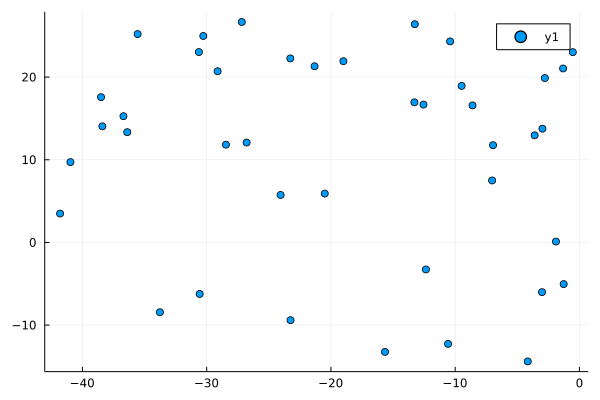

In [125]:
nc=zone_target.ntarget[1]
@show nc
plot(zone_target.X_FP[1:nc],zone_target.Y_FP[1:nc],seriestype=:scatter)
plot!()
#print(sum(zone_target.index[nc+1:end]))

In [306]:
fieldnames(Zone_Target4)

(:max_target, :zones, :ntarget, :index, :X_FP, :Y_FP, :PRIORITY, :pot_ass, :pot_coll, :theta_pos, :phi_pos)

In [168]:
#@show zone_target.zones
#@show fp_dic["zone_x"][1],fp_dic["zone_y"][1],get_zonexy(27,29,targets_dic["fp_bound"])
#@show targets_dic["PRIORITY"][zone_target.index[1:nc]]
#@benchmark tkeys=keys(targets_dic["zone_map"])
#@benchmark 1144 in tkeys
#max_target=Integer(9)*targets_dic["count_minper_zone"]
#zeros(1)
fieldnames(POSRobotBody)

(:max_seg, :nseg, :restricted_angels, :body_minmax, :body_orig, :head_minmax, :head_orig, :body_theta_limit, :head_theta_limit, :body_on_target, :head_on_target)

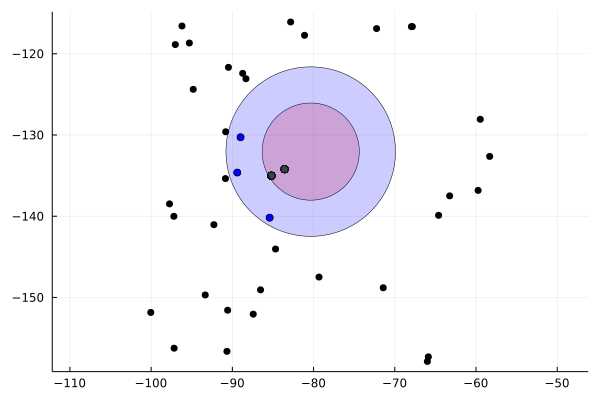

(us_priority, priority_sel) = (Integer[3400, 3200], Dict{Any, Any}(3200 => [19, 21], 3400 => Int64[]))
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possible_ass[1:count] = [19, 21]
possib

In [335]:
"""Runs the assignment for a given tile
num_fba: number of fba realization to generate
"""
function RunAssignment(fp_dic,targets_dic,num_fba=3)
    #generate two robot positioner to allocate memory to be used for efficiency
    pos_cur= POSRobotBody2(30) #Assuming we will never have more than 30 vertices
    pos_next= POSRobotBody2(30)  #This is for a neighbouring positioner
    
    #declare the strucutre to load for this particular zone with size of maximum possible
    #THis is so that only one time memory allocation is needed for efficiency
    #For any zone there can be 8 other neigbouring zone and hence a factor of 9
    max_target=Integer(9)*targets_dic["count_maxper_zone"]
    zone_target=Zone_Target4(max_target)
    
    #boolean for collision
    collided=zeros(Bool,targets_dic["ntarget"],num_fba)
    #integer for potential collision
    potential_coll=zeros(Int32,targets_dic["ntarget"],num_fba)
    
    #dictionary for collision locations
    #integer for Assignment
    pos_assigned=zeros(Int32,size(fp_dic["OFFSET_X"],1),num_fba)
    
    
    
    for zone_xy in keys(fp_dic["zone_map"])
        #get the zone
        zone_x,zone_y=split_zonexy(zone_xy,targets_dic["fp_bound"])
    
        #load the targets in zones around
        load_target_zone(zone_target,zone_x,zone_y,targets_dic["fp_bound"],targets_dic)
        #unique sorted priority for this zone
        us_priority=sort(unique(zone_target.PRIORITY[1:zone_target.ntarget[1]]),rev=true)
        
        
        #loop over positioner in this zone
        for pp in fp_dic["zone_map"][zone_xy][1]:fp_dic["zone_map"][zone_xy][2]
            #load the info for this positioner
            if(fp_dic["DEVICE_TYPE"][pp]!="POS")
                continue
            else #load positioner
                load_positioner!(pos_cur,pp,fp_dic,exc_dic)
                #pos_x=fp_dic["OFFSET_X"][pp]
                #pos_y=fp_dic["OFFSET_Y"][pp]
            end
            
            #maximum distance to which positioner reach
            max_r2=(fp_dic["LENGTH_R1"][pp]+fp_dic["LENGTH_R2"][pp])^2 
            #minimum distance to which positioner can reach
            min_r2=(fp_dic["LENGTH_R1"][pp]-fp_dic["LENGTH_R2"][pp])^2 
            
            coll_r2=(sqrt(max_r2)+pos_cur.body_minmax[2])^2 
            
            
            
            #scan for potential assignment and potential target
            for ii in 1:zone_target.ntarget[1]
                rad2=(zone_target.X_FP[ii]-pos_cur.xy[1])^2
                rad2 +=(zone_target.Y_FP[ii]-pos_cur.xy[2])^2
                if(rad2>coll_r2)#no collision
                    zone_target.pot_ass[ii]=false
                    zone_target.pot_coll[ii]=false
                elseif(rad2>max_r2)
                    zone_target.pot_ass[ii]=false
                    zone_target.pot_coll[ii]=true
                elseif(rad2>=min_r2)
                    zone_target.pot_ass[ii]=true
                    zone_target.pot_coll[ii]=false
                    #get theta_phi
                    zone_target.theta_pos[ii],zone_target.phi_pos[ii]=Hardware_dxy_to_thetaphi(
                        zone_target.X_FP[ii]-pos_cur.xy[1],zone_target.Y_FP[ii]-pos_cur.xy[2],
                        rad2,max_r2,min_r2,fp_dic["LENGTH_R1"][pp],fp_dic["LENGTH_R2"][pp])
                    #check if within theta phi range for the positioner
                    if(outside_theta_phi_range(zone_target.theta_pos[ii],zone_target.phi_pos[ii],
                                pos_cur.body_theta_limit,pos_cur.head_theta_limit) )
                        zone_target.pot_ass[ii]=false
                        zone_target.pot_coll[ii]=true
                    end
                else
                    zone_target.pot_ass[ii]=false
                    zone_target.pot_coll[ii]=false
                end
            end

            priority_sel=Dict()
            for up in us_priority
                 priority_sel[up]=findall((zone_target.PRIORITY[1:zone_target.ntarget[1]].==up) .& 
                    zone_target.pot_ass[1:zone_target.ntarget[1]])
            end
            @show us_priority,priority_sel
            
            possible_ass=zeros(Int64,100) #To store the actual possiblity
            local_ass=zeros(Int64,num_fba) #To keep the assignent in local index
            #loop over realizations
            for ri in 1:num_fba
                count=0
                for up in us_priority #do this in priority order high to low   
                    for izone in priority_sel[up]#scan all the object at chose priority
                        
                        #check if this object is collided
                        if(collided[zone_target.index[izone],ri])
                            continue
                        end
                        
                        #check if this object is in potential collision
                        if(potential_coll[zone_target.index[izone],ri]>0)
                            #Now check if this is actual collision with another positioner
                            actual_collision=false
                            if(actual_collision)
                                continue
                            end
                        end
                        
                        #This object can be assigned
                        count=count+1
                        possible_ass[count]=izone
                    end
                    
                    if(count>0)
                        @show possible_ass[1:count]
                        izone_sel=possible_ass[rand(1:count)]
                        local_ass[ri]=izone_sel
                        pos_assigned[pp,ri]=zone_target.index[izone_sel]
                        break #to brak the priority loop because we got assignment at this priority
                    end
                end
            end
            
            #udate the collision and potential collision
            uass=unique(local_ass)
            for izone in uass
                #move positioner to this target
                move_positioner(pos_cur,zone_target.theta_pos[ii],zone_target.phi_pos[ii])
                
                #determine the collisions and potential collision with head
                
                #determine the collisions and potential collision with body
                
            end
            @show pos_assigned[pp,:],targets_dic["PRIORITY"][pos_assigned[pp,:]]
            
            if(true)            
                plot_zones(pos_cur,zone_target,fp_dic)
                plot!(targets_dic["X_FP"][pos_assigned[pp,:]],
                targets_dic["Y_FP"][pos_assigned[pp,:]],seriestype=:scatter,color=:green)
                plot_circle(pos_x,pos_y,sqrt(max_r2),color=:red)
                plot_circle(pos_x,pos_y,sqrt(coll_r2),color=:blue) |>display
            end
            break
            
        end
        break
    end
end
    
    

num_fba=3
RunAssignment(fp_dic,targets_dic,num_fba)

print("Finished")

In [315]:
a=[1,2,3,4,5]
a[rand(1:1)]

1

In [296]:
"""convert positioner x,y to theta phi for the positioner
"""
function Hardware_dxy_to_thetaphi(dx,dy,rad2,max_r2,min_r2,theta_r,phi_r)
    if(isapprox(rad2,max_r2))
        # We are at the maximum arm extension.  Force phi angle to zero
        # and compute theta.
        phi = 0.0;
        theta = atan(dy, dx)
    elseif (isapprox(rad2,min_r2))
        # We are at the limit of the arm folded inwards.  Force phi angle
        # to PI and compute theta.
        phi = pi;
        theta = atan(dy,dx)
    else #We are on neither limit.
        theta_r2=theta_r*theta_r
        phi_r2=phi_r*phi_r
        
        # Use law of cosines to compute "opening" angle at the "elbow".
        opening = acos((theta_r2 + phi_r2 - rad2)/ (2.0 * theta_r * phi_r))

        # The PHI angle is just the supplement of this.
        phi = pi - opening

        # Compute the theta angle.
        # Use law of cosines to compute angle from theta arm to the line from
        # the origin to the X/Y position.
        nrm_offset = sqrt(rad2)
        txy = acos((theta_r2 + rad2 - phi_r2)/ (2 * theta_r * nrm_offset))
        theta = atan(dy, dx) - txy
    end
    
    return theta,phi
end

"""
Takes the difference of two angle
"""
function angle_diff(hi, low) 
    twopi = 2.0 * pi
    # range reduction to [-Pi, Pi)
    if (hi >= pi) 
        hi -= twopi
    elseif(hi < -pi) 
        hi += twopi
    end
    
    if (low >= pi) 
        low -= twopi
    elseif(low < -pi) 
        low += twopi
    end
    
    diff = hi - low
    if (diff > 0.0) 
        return diff
    else
        return twopi + diff
    end
end
                        
"""
theta_lim consists of MIN_T,MAX_T,OFFSET_T
phi_lim consists of MIN_P, MAX_P, OFFSET_P
"""
function outside_theta_phi_range(theta,phi,theta_lim,phi_lim)
    #= Adapted from dsihub/fibreassign
    // The definitions of the theta / phi angles and ranges can be found in
    // DESI-0899.

    // Theta angle.  The theta offset loaded from desimodel is already in global
    // focalplane coordinates (not petal-local).  The theta min / max values are
    // relative to this offset (not the coordinate system).  Compute the angle
    // difference rotating both directions from theta_zero and see if we can reach
    // it at least one of those ways.  Note that theta_min is negative to indicate
    // a clockwise rotation from theta_zero.
    =#
    diff_hi = angle_diff(theta, theta_lim[3])
    diff_lo = angle_diff(theta_lim[3], theta)

    #@show "theta",diff_hi,diff_lo,theta_lim
    #=
    // Since calling code may add theta_offset (aka theta_zero here),
    // which we then subtract off, we want to put a little margin on
    // the min/max checks.  (In most cases where we are passing
    // theta/phi values through from the desimodel inputs and we need
    // to add offsets, we also ignore this range check, so this is
    // maybe overly cautious.)
    =#
    eps = 1e-12;

    if ((   ( diff_hi > (theta_lim[2] + eps)) || ( diff_hi < (theta_lim[1] - eps)))
        & ((-diff_lo > (theta_lim[2] + eps)) || (-diff_lo < (theta_lim[1] - eps))) 
        ) 
        return true
    end

    #=
    // Phi angle.  The phi offset (phi_zero) is relative to the coordinate system
    // defined by the theta arm along the X axis.  The phi min / max values are
    // relative to this offset (not the theta-arm coordinate system).  Note that
    // a negative phi_min indicates a clockwise rotation from phi_zero.
    =#
    diff_hi = angle_diff(phi, phi_lim[3])
    diff_lo = angle_diff(phi_lim[3], phi)
    #@show "phi",diff_hi,diff_lo,phi_lim
    if ( (   ( diff_hi > (phi_lim[2] + eps)) || ( diff_hi < (phi_lim[1] - eps)) )
        & ((-diff_lo > (phi_lim[2] + eps)) || (-diff_lo < (phi_lim[1] - eps)))
        ) 
        return true
    end

    #// not outside range
    return false
end



function plot_circle(x,y,rad;color=:blue,linecolor=:black,alpha=0.2)
    theta=LinRange(0,2*pi,500)
    plot!(x .+ rad.*sin.(theta), y.+ rad.*cos.(theta),
        seriestype=[:shape,],lw=0.5,c=color,linecolor=linecolor,
        legend=false,fillalpha=alpha,aspect_ratio=1)
end

#plot_circle(1,1,2,color=:red)
phi_r=1.0
theta_r=1.0
phi_r2=phi_r^2
theta_r2=theta_r^2
min_r2=(theta_r-phi_r)^2
max_r2=(theta_r+phi_r)^2

dx=-1.2 #sqrt(2)
dy=0.4 #-sqrt(2)
rad2=dx*dx +dy*dy



if(false)
    theta,phi=Hardware_dxy_to_thetaphi(dx,dy,rad2,max_r2,min_r2,theta_r,phi_r)
    plot([0,dx],[0,dy],seriestype=:scatter,color=:red)

    plot!([0,theta_r*cos(theta),dx],[0,theta_r*sin(theta),dy],ls=:solid,color=:red)

    diff=(theta_r*cos(theta)-dx)^2 + (theta_r*sin(theta)-dy)^2

    plot_circle(0,0,theta_r;color=:blue,linecolor=:black,alpha=0.2)
    plot_circle(0,0,phi_r+theta_r;color=:green,linecolor=:black,alpha=0.1) |> display

    @show theta,phi,diff,phi_r
end

if(false)
    nt=100
    xx=rand(nt).* 3 .- 1.5
    yy=rand(1nt).* 3 .- 1.5
    th=[]
    ph=[]
    for ii in 1:nt
        rad2=xx[ii]^2+yy[ii]^2
        theta,phi=Hardware_dxy_to_thetaphi(xx[ii],yy[ii],rad2,max_r2,min_r2,theta_r,phi_r)
        append!(th,theta)
        append!(ph,phi)
    end


    @show minimum(th),maximum(th),minimum(ph),maximum(ph)
    plot(th,ph,seriestype=:scatter,color=:red)
end

outside_theta_phi_range(pi/5,0.0001,[0,2*pi,0],[0,pi/2,0])

false

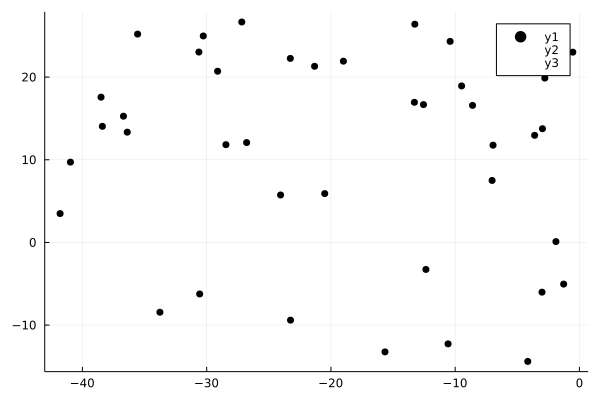

In [320]:
"""
plots the target in the zone and positioner
as as any auxiliary informatio
"""
function plot_zones(pos,zone_target,fp_dic)
    nc=zone_target.ntarget[1]
    plot(zone_target.X_FP[1:nc],zone_target.Y_FP[1:nc],seriestype=:scatter,color=:black)
    ifp=fp_dic["zone_map"][zone_target.zones[3]]
    #plot!(fp_dic["OFFSET_X"][ifp[1]:ifp[2]],fp_dic["OFFSET_Y"][ifp[1]:ifp[2]],
    #    seriestype=:scatter,color=:green,markersize=10)
    
    iass=findall(zone_target.pot_ass[1:nc])
    plot!(zone_target.X_FP[iass],zone_target.Y_FP[iass],seriestype=:scatter,color=:red)
    icoll=findall(zone_target.pot_coll[1:nc])
    plot!(zone_target.X_FP[icoll],zone_target.Y_FP[icoll],seriestype=:scatter,color=:blue) 
    
    
end

plot_zones(pos,zone_target,fp_dic)

In [144]:
fieldnames(pos)

LoadError: MethodError: no method matching fieldnames(::POSRobotBody)
[0mClosest candidates are:
[0m  fieldnames([91m::Core.TypeofBottom[39m) at /usr/local/Cellar/julia/1.7.1/share/julia/base/reflection.jl:188
[0m  fieldnames([91m::Type{<:Tuple}[39m) at /usr/local/Cellar/julia/1.7.1/share/julia/base/reflection.jl:190
[0m  fieldnames([91m::DataType[39m) at /usr/local/Cellar/julia/1.7.1/share/julia/base/reflection.jl:185
[0m  ...

In [30]:
for tt in fieldnames( POSRobotBody)
    println(tt,' ',getfield(pos,tt))
end

max_seg 30
nseg Integer[16, 8]
restricted_angels Bool[0, 0]
body_minmax [1.5500757694244385, 4.451638221740723]
body_orig [0.8140000104904175 -3.2360000610351562; 2.0829999446868896 -2.7070000171661377; 2.61299991607666 -2.6649999618530273; 4.1539998054504395 -2.759000062942505; 4.695000171661377 -1.6799999475479126; 5.093999862670898 -0.5400000214576721; 5.093999862670898 0.5400000214576721; 4.830999851226807 1.2910000085830688; 4.235000133514404 1.9329999685287476; 3.431999921798706 2.2829999923706055; 2.2799999713897705 2.2829999923706055; -1.9019999504089355 -0.9350000023841858; -2.006999969482422 -2.6649999618530273; -1.1390000581741333 -3.13700008392334; -0.17000000178813934 -3.3320000171661377; 0.8140000104904175 -3.2360000610351562; 0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0]
head_minmax [1.4714999198913574, 3.8112893104553223]
head_orig [3.9670000076293945 0.0; 3.9179999828338623 1.01400005817413

In [668]:
xx.nseg[1]=4.5

LoadError: InexactError: Int64(4.5)

In [653]:
#xx.body[1,1]=3
@show xx

xx = Test2([3.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0])


Test2([3.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0])

In [621]:
keys(fp_dic)

KeySet for a Dict{Any, Any} with 17 entries. Keys:
  "LENGTH_R2"
  "LENGTH_R1"
  "MAX_P"
  "zone_y"
  "OFFSET_P"
  "LOCATION"
  "OFFSET_Y"
  "MAX_T"
  "zone_x"
  "OFFSET_X"
  "zone_map"
  "DEVICE_TYPE"
  "MIN_T"
  "OFFSET_T"
  "EXCLUSION"
  "MIN_P"
  "STATE"

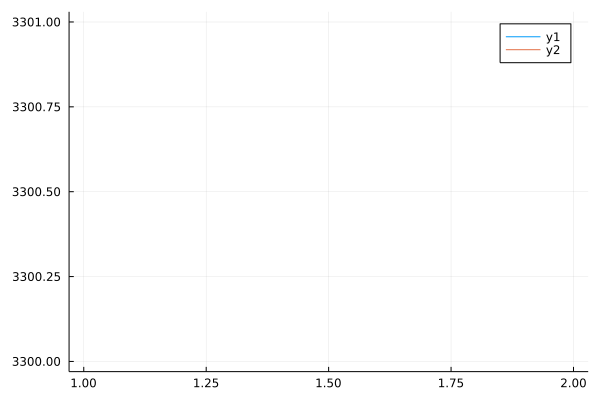

(minimum(tmp), maximum(tmp), mean(tmp)) = (0, 2, 0.1023142509135201)


(0, 2, 0.1023142509135201)

In [597]:
tmp=[]
plot([1],[3300])
#tdic=targets_dic
tdic=fp_dic
for tkey in keys(tdic["zone_map"])
    bi=tdic["zone_map"][tkey][1]
    ei=tdic["zone_map"][tkey][2]
    diff=ei-bi
    append!(tmp,diff)
    #println(tkey,' ',diff)
    if((ei-bi>0) & false)
        pdiff=tdic["PRIORITY"][bi:ei-1]-tdic["PRIORITY"][bi+1:ei]
        if(minimum(pdiff)<0)
            println(tkey,' ',bi,' ',ei,' ',tdic["PRIORITY"][bi:ei])
        end
    end
    #plot!(tdic["PRIORITY"][bi:ei])
end
plot!([1],[3300]) |> display
@show minimum(tmp),maximum(tmp),mean(tmp)

In [553]:
#plot(targets_dic["PRIORITY"],series_type=:scatter)
indexin(targets_dic["PRIORITY"])

LoadError: MethodError: no method matching indexin(::Vector{Any})
[0mClosest candidates are:
[0m  indexin(::Any, [91m::AbstractArray[39m) at /usr/local/Cellar/julia/1.7.1/share/julia/base/array.jl:2352

In [458]:
nfp=size(fp_dic["DEVICE_TYPE"],1)
ii=1
fp_dic["DEVICE_TYPE"][ii]
pos_xzone=fp_dic["zone_x"][ii]
pos_yzone=fp_dic["zone_y"][ii]

for xz in [pos_xzone-1,pos_xzone,pos_xzone+1]
    for yz in [pos_xzone]


"POS"

In [95]:
mock_dir="/Users/shadab/Documents/Projects/MockFBA/mocks/"
#output firectory
outdir="$(mock_dir)JLD2_data/"

tt=1
tile_id=tiles_dic["TILEID"][tt]
tile_pass=0
group=sky
tracer="QSO"
outfile=@sprintf("%s%s_ph000.jld2",outdir,tracer)
tracer_tile=MockFBA.Load_tracers_intile(outfile,tile_id,tile_pass,group,["RA","DEC","X_UNIT","Y_UNIT","Z_UNIT"])

Dict{Any, Any} with 9 entries:
  "Y_UNIT"    => Any[0.338626, 0.334979, 0.331488, 0.341667, 0.339976, 0.33037,…
  "ref_group" => "SGC"
  "PASS"      => 0
  "RA"        => Any[19.7975, 19.5713, 19.3591, 19.979, 19.8756, 19.2913, 19.96…
  "TILEID"    => 1006
  "Z_UNIT"    => Any[0.0205106, 0.000765925, 4.28769e-5, -0.00716611, -0.004022…
  "X_UNIT"    => Any[0.940697, 0.942225, 0.94346, 0.939794, 0.940425, 0.943851,…
  "index"     => Any[268849, 268882, 268888, 269015, 269047, 269050, 269052, 27…
  "DEC"       => Any[1.17525, 0.0438843, 0.00245667, -0.410591, -0.230469, -0.0…

size(tracer_tile["RA"]) = (2877,)


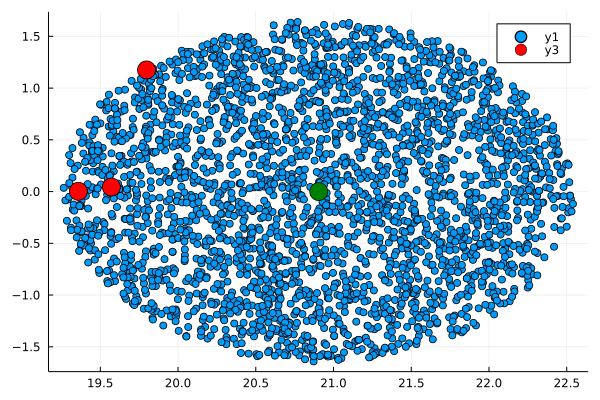

In [96]:
@show size(tracer_tile["RA"])
#@show tile_id
plot(tracer_tile["RA"],tracer_tile["DEC"],seriestype=:scatter)
tt=1
plot!([tiles_dic["RA"][tt]],[tiles_dic["DEC"][tt]],seriestype=:scatter,color = "green", label = "", markersize = 10)


plot!(tracer_tile["RA"][1:3],tracer_tile["DEC"][1:3],seriestype=:scatter,color=:red,markersize = 10)

In [137]:
plate_scale=load_platescale("focalplane/")
#r1=get_radius_mm("focalplane/",[0,0.1,0.2,2.0,5])
#r2=get_radius_mm(plate_scale,[0,0.1,0.2,2.0,5])

telra=tiles_dic["RA"][tt]
teldec=tiles_dic["DEC"][tt]


#x_focalplane, y_focalplane=radec2xy_focalplane(telra, teldec, tracer_tile["RA"],tracer_tile["DEC"],plate_scale)
x_focalplane, y_focalplane= xyz_unit_2_xy_focalplane(telra, teldec, 
    tracer_tile["X_UNIT"],tracer_tile["Y_UNIT"],tracer_tile["Z_UNIT"],plate_scale)

([281.03215489009057, 333.7930147129554, 390.9021744820831, 228.83939919064844, 254.75781571740484, 409.57651513987366, 232.9783568180235, 355.45698731769335, 331.56965016440176, 374.0499693148365  …  -141.29108423110821, -220.76780523635486, 172.6003882662159, 151.91483649499165, 208.2043628042851, -220.54592749491445, -336.7199954237341, -109.78251650376639, -169.4820310580343, -75.50331607901167], [298.2919227453517, 10.984113963983743, 0.6212718482805254, -101.4723467023148, -57.04057090559406, -19.573609883812548, -144.923436700104, 87.70758299889141, -162.87250712253177, -41.32574545060786  …  297.6728913406613, 281.26411078293233, 158.23697810846423, 220.20424364280848, 276.8196060909303, 281.3467525310058, -139.04408147278244, -255.8969038518275, -229.77338592853908, -47.93447728867834])

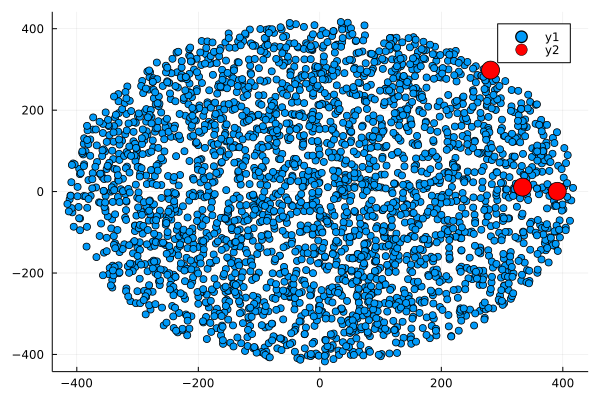

In [138]:
plot(x_focalplane, y_focalplane,seriestype=:scatter)

plot!(x_focalplane[1:3], y_focalplane[1:3],seriestype=:scatter,color=:red,markersize = 10)

In [173]:



grid_scale=10
fp_bound=get_bound_focal_plane(x_focalplane, y_focalplane,grid_scale;pad=0.2)
zone_x,zone_y=Assign_xy_zone(x_focalplane,y_focalplane,fp_bound)

(Int16[68, 73, 79, 63, 66, 81, 63, 75, 73, 77  …  27, 19, 57, 55, 61, 19, 7, 30, 24, 33], Int16[70, 42, 41, 31, 35, 39, 26, 49, 25, 36  …  70, 68, 56, 62, 68, 68, 27, 15, 18, 36])

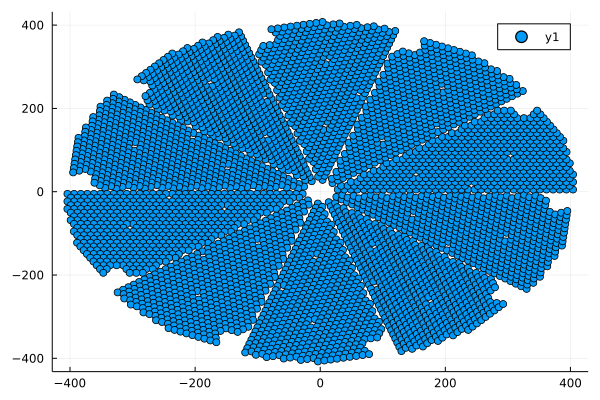

In [76]:
plot(fiber["X"], fiber["Y"],seriestype=:scatter)

In [24]:
tab1=readdlm("focalplane/rzsn.txt", Float64,comments=true,skipstart=8)

421×4 Matrix{Float64}:
   0.0    0.0         0.0    0.001722
   1.0   -0.0001      1.0    0.010606
   2.0   -0.000402    2.0    0.019486
   3.0   -0.000904    3.0    0.028362
   4.0   -0.001607    4.0    0.037235
   5.0   -0.002511    5.0    0.046104
   6.0   -0.003616    6.0    0.05497
   7.0   -0.004922    7.0    0.063833
   8.0   -0.00643     8.0    0.072694
   9.0   -0.008138    9.0    0.081551
  10.0   -0.010047   10.0    0.090407
  11.0   -0.012158   11.0    0.09926
  12.0   -0.01447    12.0    0.108111
   ⋮                         
 409.0  -18.8279    409.59   5.91766
 410.0  -18.9266    410.595  5.95083
 411.0  -19.0256    411.6    5.98417
 412.0  -19.125     412.605  6.01768
 413.0  -19.2247    413.61   6.05136
 414.0  -19.3247    414.615  6.0852
 415.0  -19.4251    415.62   6.1192
 416.0  -19.5257    416.625  6.15336
 417.0  -19.6267    417.63   6.18767
 418.0  -19.7281    418.635  6.22212
 419.0  -19.8297    419.64   6.25671
 420.0  -19.9317    420.645  6.29143

In [106]:
theta=pi/5
cth=cos(theta)

0.8090169943749475

In [108]:
@benchmark sin(theta)

BenchmarkTools.Trial: 10000 samples with 996 evaluations.
 Range (min … max):  15.620 ns … 79.441 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     17.195 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   18.504 ns ±  2.983 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃ ▅▁▄▄█▄▅▃▇▃▂▁▁▁▂▁ ▂▁       ▄▅ ▂▅▁                ▂▃▁  ▁▂▂▂ ▂
  █▇██████████████████████▅▇████████▆▇▇▅▄█▅▅▅█▅▄▄█▆▁███▆▅████ █
  15.6 ns      Histogram: log(frequency) by time      26.1 ns <

 Memory estimate: 16 bytes, allocs estimate: 1.

In [107]:
@benchmark acos(cth)

BenchmarkTools.Trial: 10000 samples with 993 evaluations.
 Range (min … max):  22.595 ns …  7.109 μs  ┊ GC (min … max): 0.00% … 99.60%
 Time  (median):     24.583 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   26.915 ns ± 70.941 ns  ┊ GC (mean ± σ):  2.63% ±  1.00%

   ▄▇▅▅▇██▆▇▄▄▁ ▁▁ ▁    ▃▃▅▆▃▄▅▂▁                ▂▂▁ ▁▁▁      ▃
  ████████████████████████████████▇▆▅▆▆▅▅▆▆▅▅▆▆▃▅███▇███▇█▆▆▅ █
  22.6 ns      Histogram: log(frequency) by time      38.2 ns <

 Memory estimate: 16 bytes, allocs estimate: 1.

In [110]:
@benchmark sqrt(1-(cth*cth))

BenchmarkTools.Trial: 10000 samples with 982 evaluations.
 Range (min … max):  44.831 ns …   7.143 μs  ┊ GC (min … max): 0.00% … 99.27%
 Time  (median):     48.425 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   53.748 ns ± 152.051 ns  ┊ GC (mean ± σ):  6.32% ±  2.22%

  ▁ ▄▃▄▄▇█▄▁▁▄▂                 ▃▁ ▂▂                ▁         ▁
  ██████████████▇▆█▆▇▇▆▇▇▆▇▇▅▆▄███▆██▇▅▆▅▄▅▅▄▃▄▆▄▄▄▅▅██▆▅▃█▆▄▅ █
  44.8 ns       Histogram: log(frequency) by time      74.7 ns <

 Memory estimate: 48 bytes, allocs estimate: 3.

In [15]:
# Dependent variable
u = [14.7, 11.51, 10.41, 14.95, 12.24, 11.22]
# Independent variable
t = [0.0, 62.25, 109.66, 162.66, 205.8, 252.3]


6-element Vector{Float64}:
   0.0
  62.25
 109.66
 162.66
 205.8
 252.3

In [271]:
desi_exc=YAML.load_file("focalplane/desi-exclusion_2019-09-16T00:00:00.yaml")
tarr=desi_exc["default"]["phi"]["segments"][1]
#poly=@SMatrix zeros(Float32,size(tarr,1),2)
seg=zeros(size(tarr,1),2)
for ii in 1:size(tarr,1)
    seg[ii,:]=tarr[ii]
end
poly=SMatrix{8,2,Float32}(seg)

8×2 SMatrix{8, 2, Float32, 16} with indices SOneTo(8)×SOneTo(2):
  3.967   0.0
  3.918   1.014
  3.269   1.583
 -1.172   1.037
 -1.172  -1.037
  3.269  -1.583
  3.918  -1.014
  3.967   0.0

In [7]:
seg=zeros(size(tarr,1),2)
for ii in 1:size(tarr,1)
    seg[ii,:]=tarr[ii]
end

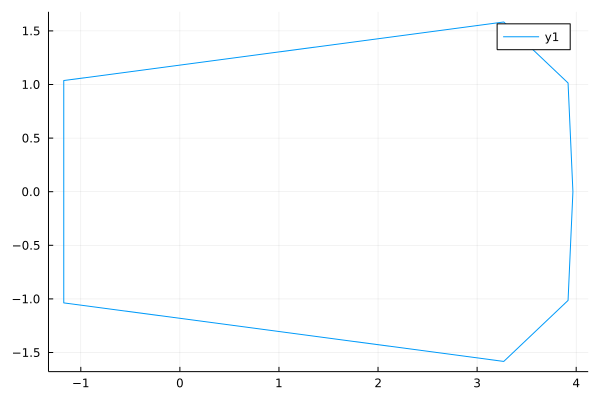

In [266]:
plot(poly[:,1],poly[:,2],ls=:solid)

In [405]:
using bits

LoadError: ArgumentError: Package bits not found in current path:
- Run `import Pkg; Pkg.add("bits")` to install the bits package.


In [9]:





poly=seg

xx=[1,2,-3]
@show xx,xx[begin+1:end-1], bits.(xx)
#pointxy_inpoly(x,y,poly)

(xx, xx[begin + 1:end - 1], bits.(xx)) = ([1, 2, -3], [2], Bits.BitVector1{Int64}[<00000000 00000000 00000000 00000000 00000000 00000000 00000000 00000001>, <00000000 00000000 00000000 00000000 00000000 00000000 00000000 00000010>, <11111111 11111111 11111111 11111111 11111111 11111111 11111111 11111101>])


([1, 2, -3], [2], Bits.BitVector1{Int64}[<00000000 00000000 00000000 00000000 00000000 00000000 00000000 00000001>, <00000000 00000000 00000000 00000000 00000000 00000000 00000000 00000010>, <11111111 11111111 11111111 11111111 11111111 11111111 11111111 11111101>])

In [91]:
#=
"This is to determine whether line segments intersect
 Arguments:
    p1,p2
v2_arr
"
function LineSeg_Intersecting(p1,p2,v2_arr)#;sel1_inpoly=nothing,sel2_inpoly=nothing)
    
    
    
    #Number of segments
    nseg=size(v2_arr,1)-1
    
    #equation of line for first line segment
    # We want the line in linear equation standard form: A*x + B*y + C = 0
    a1=p2[2]-p1[2]
    b1=p1[1]-p2[1]
    c1=(p2[1]*p1[2])- (p1[1]*p2[2])
    
    d1=zeros(nseg)
    d2=zeros(nseg)
    #sel1_inpoly=nothing
    #sel2_inpoly=nothing
    
    #if(sel1_inpoly==nothing)
    #    sel1_inpoly=trues(nseg)
    #end
    
    #if(sel2_inpoly==nothing)
    #    sel2_inpoly=trues(nseg)
    #end
    
    #every point which positive is on one side negative on another
    @. d1 = (a1 * v2_arr[begin+1:end,1]) + (b1 * v2_arr[begin+1:end,2]) + c1;
    @. d2 = (a1 * v2_arr[begin:end-1,1]) + (b1 * v2_arr[begin:end-1,2]) + c1;
    
    #@show sel1_inpoly
    #sel1_inpoly .= @. !( ((d1 > 0) & (d2 > 0)) || ((d1 < 0) & (d2 < 0)))
    sel1_inpoly .= @. !( (d1*d2  > 0) || (d1==0) || (d2==0))
    id2_zero=findall(d2.==0)
    if(size(id2_zero,1)>0)
        sel1_inpoly[id2_zero].=false
    end
    
    #id1_zero= findall(d1.==0)
    #if(size(id1_zero,1)>0)
    #    sel1_inpoly[id1_zero+1].=false
    #end
    
    for ii in 1:nseg
        println(ii,poly[ii,:],sel1_inpoly[ii],d1[ii],d2[ii],d1[ii]*d2[ii])
    end
    
    #Now check if other way around things intersect
    a2=v2_arr[begin+1:end,2] .- v2_arr[begin:end-1,2]
    b2=v2_arr[begin:end-1,1] .- v2_arr[begin+1:end,1]
    c2=(v2_arr[begin+1:end,1] .* v2_arr[begin:end-1,2]) .- (v2_arr[begin:end-1,1] .*v2_arr[begin+1:end,2])
    
    @. d1 =(a2 * p1[1]) + (b2 * p1[2]) + c2;
    @. d2 =(a2 * p2[1]) + (b2 * p2[2]) + c2;
    
    sel2_inpoly = @. !( ( (d1 > 0) & (d2 > 0)) || ( (d1 < 0) & (d2 < 0)))
    

    

    sel12=sel1_inpoly .& sel2_inpoly
    
    for ii in 1:nseg
        println(ii,poly[ii,:],sel1_inpoly[ii],sel2_inpoly[ii],sel12[ii])
    end
   
    #return sel2_inpoly .& sel2_inpoly
    if(true)
        
        plot(poly[:,1],poly[:,2],ls=:solid,color=:red)
        for ii in 1:nseg
            if(sel12[ii])
                plot!(poly[ii:ii+1,1],poly[ii:ii+1,2],ls=:solid,color=:blue)
            end
        end
        plot!([p1[1],p2[1]],[p1[2],p2[2]],ls=:solid,color=:black)  
        plot!(poly[:,1],poly[:,2],seriestype=:scatter,color=:black) |> display
    end
end
=#



Finished


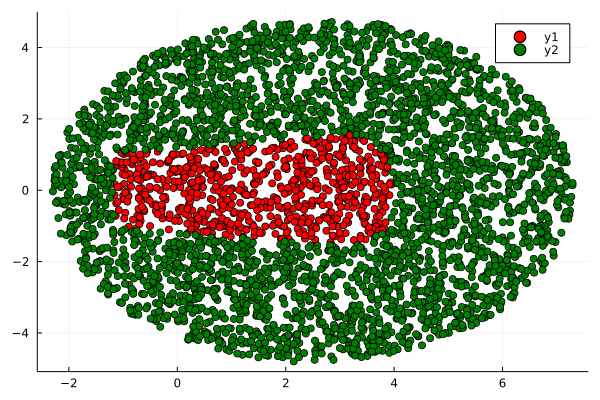

In [92]:
plot(x[in_poly],y[in_poly],seriestype=:scatter,color=:red)
plot!(x[in_circle],y[in_circle],seriestype=:scatter,color=:green)

10000-element BitVector:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [86]:
@benchmark PointsInPoly_and_PadedeCircle!(x,y,poly,pad_circle;dist2=dist2,in_poly=in_poly,in_circle=in_circle)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  213.935 μs …   8.306 ms  ┊ GC (min … max): 0.00% … 95.52%
 Time  (median):     238.752 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   270.126 μs ± 305.614 μs  ┊ GC (mean ± σ):  5.21% ±  4.49%

   ▁██▆▃▅▃▁▂▁▂▅▅▇▆▄▂▂▁▁▁▁▁                                      ▂
  ▄██████████████████████████▇▇▇▇▇▇▇▆▇▅▆▆▆▆▆▆▄▅▅▆▆▄▅▅▆▆▅▆▅▆▄▄▅▅ █
  214 μs        Histogram: log(frequency) by time        459 μs <

 Memory estimate: 182.19 KiB, allocs estimate: 2332.

In [583]:
  

nseg=size(poly,1)-1
p1=[0,0]
p2=poly[4,:]#[5,0]
sel1_inpoly=trues(nseg)
sel2_inpoly=trues(nseg)
#@show nseg
#LineSeg_Intersecting(p1,p2,poly)#,sel1_inpoly=sel1_inpoly,sel2_inpoly=sel2_inpoly)


#wn=winding_count(p1,poly)
wn=InPolyWinding_loop(p1,poly)
if(true)
    x_cen=0
    y_cen=0
    nobj=10000
    x=SVector{nobj,Float64}(8.0.*rand(nobj) .- 2)
    y=SVector{nobj,Float64}(4.0.*rand(nobj) .- 2)
    wn=zeros(Bool,nobj)

    for ii in 1:nobj
        #wn[ii]=winding_count([x[ii],y[ii]],poly)
        wn[ii]=InPolyWinding_loop([x[ii],y[ii]],poly)
    end
    #wn =winding_count.([x;y],Ref(poly))

    if(true)
        plot(poly[:,1],poly[:,2],ls=:solid,color=:black)

        #ind_out=findall(wn)
        ind_in=findall(wn)
        plot!(x,y,seriestype=:scatter,color=:grey)
        plot!(x[  ind_in],y[ ind_in],seriestype=:scatter,color=:red)
        #if(wn==0)
        #    plot!([p1[1]],[p1[2]],seriestype=:scatter,color=:grey)
        #else
        #    plot!([p1[1]],[p1[2]],seriestype=:scatter,color=:red)
        #end

        plot!(poly[:,1],poly[:,2],seriestype=:scatter,color=:black,legend=false) |> display
    end
end

In [570]:
@benchmark wn=winding_count(p1,poly;dist=dist)

BenchmarkTools.Trial: 10000 samples with 10 evaluations.
 Range (min … max):  1.749 μs …  1.880 ms  ┊ GC (min … max):  0.00% … 99.84%
 Time  (median):     1.963 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   2.426 μs ± 26.399 μs  ┊ GC (mean ± σ):  15.38% ±  1.41%

     ▁▃██▄▁                                                   
  ▂▃▆██████▆▄▄▃▃▃▄▅▅▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▂▂▁▂▂▂▂▂▂▂▂ ▃
  1.75 μs        Histogram: frequency by time        3.54 μs <

 Memory estimate: 3.06 KiB, allocs estimate: 44.

In [582]:


@benchmark wn=InPolyWinding_loop(p1,poly)

BenchmarkTools.Trial: 10000 samples with 964 evaluations.
 Range (min … max):  65.113 ns … 275.261 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     68.728 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   76.206 ns ±  13.238 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▅▅▂█▅         ▆▁▇▂▁            ▃                             ▂
  ████████▃██▁█▅█████▇▇▅▃▇▆▇▆▅█▆▆█▆▆▆▆▆▇▆▆▆▆▆▅▆▅▅▆▄▄▅▅▅▅▁▅▅▄▄▅ █
  65.1 ns       Histogram: log(frequency) by time       133 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [305]:
using Profile
using StatProfilerHTML

In [383]:

x_cen=0
y_cen=0
nobj=10000
x=SVector{nobj,Float64}(2.0.*rand(nobj) .- 1)
y=SVector{nobj,Float64}(2.0.*rand(nobj) .- 1)
radiuses=[0.1,0.2,0.4]

sel=Dict()
for rr in 1:size(radiuses,1)
    sel[rr]=zeros(Bool,3*nobj)
end

dist2=zeros(Float64,4*nobj)
#view(dist2,[1,2,3])

#point_in_circle!(x,y,x_cent=0.2,y_cent=0.3,dist2=view(dist2,1:nobj),
#    radius1=radiuses[1],sel_rad1=view(sel[1],1:nobj)
#    ,radius2=radiuses[2],sel_rad2=view(sel[2],1:nobj),radius3=radiuses[3],sel_rad3=view(sel[3],1:nobj))
#tp=unique(keys(sel))

10000-element view(::Vector{Bool}, 1:10000) with eltype Bool:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [306]:
@profile sel=point_in_circle(x,y,x_cent=0.2,y_cent=0.3,radiuses=[0.1,0.2,0.4])

Dict{Any, Any} with 3 entries:
  2 => Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  3 => Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
  1 => Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [388]:
@benchmark point_in_circle!(x,y,x_cent=0.2,y_cent=0.3,dist2=view(dist2,1:nobj),
    radius1=radiuses[1],sel_rad1=view(sel[1],1:nobj)
    ,radius2=radiuses[2],sel_rad2=view(sel[2],1:nobj),radius3=radiuses[3],sel_rad3=view(sel[3],1:nobj))
#point_in_circle!(x,y,x_cent=0.2,y_cent=0.3,radiuses=[0.1,0.2,0.4],sel=sel)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  13.645 μs … 76.029 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     15.595 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   16.593 μs ±  3.062 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

       ▁ ▅█▆▅▂▂       ▁ ▄▅▃▂▃▃▂                               ▂
  ████▆█▇███████▇█▅█▇██▆████████▆▇▆▄▄▅▃▄▃▃▁▄▃▃▃▄▄▃▄▄▄▄▃▄▄▄▅▁▃ █
  13.6 μs      Histogram: log(frequency) by time      26.6 μs <

 Memory estimate: 832 bytes, allocs estimate: 14.

In [307]:
Profile.print()

Overhead ╎ [+additional indent] Count File:Line; Function
 ╎1 @Base/task.jl:423; (::IJulia.var"#15#18")()
 ╎ 1 @IJulia/src/eventloop.jl:8; eventloop(socket::ZMQ.Socket)
 ╎  1 @Base/essentials.jl:714; invokelatest
 ╎   1 @Base/essentials.jl:716; #invokelatest#2
 ╎    1 ...rc/execute_request.jl:67; execute_request(socket::ZMQ.Socke...
 ╎     1 ...c/SoftGlobalScope.jl:65; softscope_include_string(m::Modu...
 ╎    ╎ 1 @Base/loading.jl:1196; include_string(mapexpr::typeof...
 ╎    ╎  1 @Base/boot.jl:373; eval
Total snapshots: 1


In [548]:
statprofilehtml()

┌ Info: Wrote profiling output to file:///Users/shadab/Documents/Projects/MockFBA/statprof/index.html .
└ @ StatProfilerHTML /Users/shadab/.julia/packages/StatProfilerHTML/FRimo/src/StatProfilerHTML.jl:27


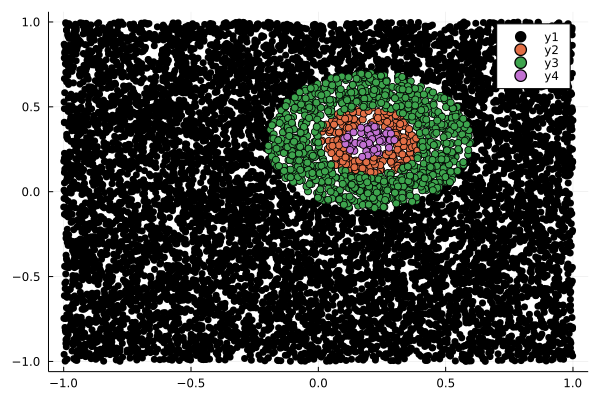

sum(sel[tkey]) = 228
sum(sel[tkey]) = 957
sum(sel[tkey]) = 72


In [386]:
function plot_poly_sel(x,y,sel;skip=0)
    nobj=size(x,1)
    
    plot(x,y,seriestype=:scatter,color=:black)
    key_list=unique(keys(sel))
    
    for nn in 1:length(key_list)
        tkey=key_list[nn]
        @show sum(sel[tkey])
        if(nn<length(key_list))
            plot!(x[sel[tkey][1:nobj]],y[sel[tkey][1:nobj]],seriestype=:scatter,color=:auto)
        else
            plot!(x[sel[tkey][1:nobj]],y[sel[tkey][1:nobj]],seriestype=:scatter,color=:auto) |> display
        end
    end
    
end

plot_poly_sel(x,y,sel;skip=0)

In [121]:
Pkg.add("DataFrames")
using DataFrames

   Resolving package versions...
  No Changes to `~/Documents/Projects/MockFBA/Project.toml`
  No Changes to `~/Documents/Projects/MockFBA/Manifest.toml`
Precompiling project...
  ✓ MockFBA
  1 dependency successfully precompiled in 1 seconds (124 already precompiled)
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version


In [ ]:
using BenchM

In [180]:
df=CSV.read("focalplane/desi-focalplane_2019-09-16T00:00:00.ecsv", DataFrame;delim=" ",comment="#",header=1)
#df = DataFrame(CSV.File("focalplane/desi-focalplane_2019-09-16T00:00:00.ecsv"))

5430×24 DataFrame
  Row │ PETAL  DEVICE  LOCATION  PETAL_ID  DEVICE_ID  DEVICE_TYPE  SLITBLOCK   ⋯
      │ Int64  Int64   Int64     Int64     String7    String3      Int64       ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │     7       0      7000         2  M03139     POS                 18   ⋯
    2 │     7       1      7001         2  M03621     POS                 18
    3 │     7       2      7002         2  M03500     POS                 18
    4 │     7       3      7003         2  M03730     POS                 18
    5 │     7       4      7004         2  M03430     POS                 18   ⋯
    6 │     7       5      7005         2  M02702     POS                 19
    7 │     7       6      7006         2  M02813     POS                 19
    8 │     7       7      7007         2  M03426     POS                 18
    9 │     7       8      7008         2  M03567     POS                 19   ⋯
   10 │     7       9      7009         2  M03446     POS                 19
   11 │     7      10      7010         2  M03914     POS                 18
  ⋮   │   ⋮      ⋮        ⋮         ⋮          ⋮           ⋮           ⋮       ⋱
 5421 │     6     533      6533        11  NONE       OPT                 -1
 5422 │     6     534      6534        11  NONE       FIF                 -1   ⋯
 5423 │     6     535      6535        11  NONE       NON                 -1
 5424 │     6     536      6536        11  NONE       NON                 -1
 5425 │     6     537      6537        11  NONE       NON                 -1
 5426 │     6     538      6538        11  NONE       NON                 -1   ⋯
 5427 │     6     539      6539        11  NONE       NON                 -1
 5428 │     6     540      6540        11  NONE       NON                 -1
 5429 │     6     541      6541        11  NONE       GIF                 -1
 5430 │     6     542      6542        11  NONE       GIF                 -1   ⋯
                                                17 columns and 5409 rows omitted

In [185]:
df1=select(df,["OFFSET_X","OFFSET_Y","LOCATION","MIN_T","MAX_T","MIN_P","MAX_P",
        "OFFSET_T","OFFSET_P","LENGTH_R1","LENGTH_R2"])

5430×11 DataFrame
  Row │ OFFSET_X   OFFSET_Y   LOCATION  MIN_T     MAX_T    MIN_P      MAX_P    ⋯
      │ Float64    Float64    Int64     Float64   Float64  Float64    Float64  ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │  -25.8185   12.3289       7000  -196.291  196.291   -6.51024    185.0  ⋯
    2 │  -34.246    18.4518       7001  -197.488  197.488   -3.73663    185.0
    3 │  -35.3534    8.06761      7002  -196.093  196.093   -9.90478    185.0
    4 │  -42.6734   24.5747       7003  -196.253  196.253   -3.20006    185.0
    5 │  -43.7821   14.1886       7004  -196.979  196.979   -2.10851    185.0  ⋯
    6 │  -51.1007   30.6974       7005  -196.321  196.321   -3.93693    185.0
    7 │  -52.2099   20.3109       7006  -195.014  195.014   -7.82279    185.0
    8 │  -53.3373    9.89538      7007  -195.453  195.453   -5.81163    185.0
    9 │  -59.527    36.8195       7008  -196.524  196.524   -6.71118    185.0  ⋯
   10 │  -60.6323   26.4386       7009  -196.282  196.282   -4.92875    185.0
   11 │  -61.7601   16.0243       7010  -195.256  195.256  -10.8619     185.0
  ⋮   │     ⋮          ⋮         ⋮         ⋮         ⋮         ⋮         ⋮     ⋱
 5421 │ -274.695   303.0          6533     0.0      0.0      0.0          0.0
 5422 │ -281.663   295.234        6534     0.0      0.0      0.0          0.0  ⋯
 5423 │ -288.636   287.473        6535     0.0      0.0      0.0          0.0
 5424 │ -295.631   279.733        6536     0.0      0.0      0.0          0.0
 5425 │ -302.635   271.999        6537     0.0      0.0      0.0          0.0
 5426 │ -309.652   264.28         6538     0.0      0.0      0.0          0.0  ⋯
 5427 │ -316.668   256.555        6539     0.0      0.0      0.0          0.0
 5428 │ -323.702   248.804        6540     0.0      0.0      0.0          0.0
 5429 │ -288.634   216.997        6541     0.0      0.0      0.0          0.0
 5430 │ -303.149   277.108        6542     0.0      0.0      0.0          0.0  ⋯
                                                 4 columns and 5409 rows omitted

In [186]:
save("dftest.jld2", "df1", df1)
#load("dftest.jld2", "df")
#plot(df.MIN_P,df.MAX_P,seriestype=:scatter)

In [187]:
@btime df1=load("dftest.jld2", "df1")

  1.262 ms (2979 allocations: 964.67 KiB)


5430×11 DataFrame
  Row │ OFFSET_X   OFFSET_Y   LOCATION  MIN_T     MAX_T    MIN_P      MAX_P    ⋯
      │ Float64    Float64    Int64     Float64   Float64  Float64    Float64  ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │  -25.8185   12.3289       7000  -196.291  196.291   -6.51024    185.0  ⋯
    2 │  -34.246    18.4518       7001  -197.488  197.488   -3.73663    185.0
    3 │  -35.3534    8.06761      7002  -196.093  196.093   -9.90478    185.0
    4 │  -42.6734   24.5747       7003  -196.253  196.253   -3.20006    185.0
    5 │  -43.7821   14.1886       7004  -196.979  196.979   -2.10851    185.0  ⋯
    6 │  -51.1007   30.6974       7005  -196.321  196.321   -3.93693    185.0
    7 │  -52.2099   20.3109       7006  -195.014  195.014   -7.82279    185.0
    8 │  -53.3373    9.89538      7007  -195.453  195.453   -5.81163    185.0
    9 │  -59.527    36.8195       7008  -196.524  196.524   -6.71118    185.0  ⋯
   10 │  -60.6323   26.4386       7009  -196.282  196.282   -4.92875    185.0
   11 │  -61.7601   16.0243       7010  -195.256  195.256  -10.8619     185.0
  ⋮   │     ⋮          ⋮         ⋮         ⋮         ⋮         ⋮         ⋮     ⋱
 5421 │ -274.695   303.0          6533     0.0      0.0      0.0          0.0
 5422 │ -281.663   295.234        6534     0.0      0.0      0.0          0.0  ⋯
 5423 │ -288.636   287.473        6535     0.0      0.0      0.0          0.0
 5424 │ -295.631   279.733        6536     0.0      0.0      0.0          0.0
 5425 │ -302.635   271.999        6537     0.0      0.0      0.0          0.0
 5426 │ -309.652   264.28         6538     0.0      0.0      0.0          0.0  ⋯
 5427 │ -316.668   256.555        6539     0.0      0.0      0.0          0.0
 5428 │ -323.702   248.804        6540     0.0      0.0      0.0          0.0
 5429 │ -288.634   216.997        6541     0.0      0.0      0.0          0.0
 5430 │ -303.149   277.108        6542     0.0      0.0      0.0          0.0  ⋯
                                                 4 columns and 5409 rows omitted

In [188]:
names(df1)

11-element Vector{String}:
 "OFFSET_X"
 "OFFSET_Y"
 "LOCATION"
 "MIN_T"
 "MAX_T"
 "MIN_P"
 "MAX_P"
 "OFFSET_T"
 "OFFSET_P"
 "LENGTH_R1"
 "LENGTH_R2"

In [200]:
df = DataFrame(rand(10,5),:auto);

#save("dftest1.jld2", "zone/df", df)
#load("dftest.jld2", "df")

In [139]:
tmp=load("zonedftest.jld2", "df")

10×5 DataFrame
 Row │ x1        x2        x3         x4        x5       
     │ Float64   Float64   Float64    Float64   Float64  
─────┼───────────────────────────────────────────────────
   1 │ 0.264476  0.928675  0.0966761  0.759024  0.097836
   2 │ 0.964381  0.333932  0.314944   0.309851  0.164763
   3 │ 0.767719  0.382941  0.283711   0.362543  0.858231
   4 │ 0.401762  0.90793   0.6549     0.625919  0.915271
   5 │ 0.703934  0.270091  0.320021   0.193696  0.88046
   6 │ 0.810299  0.762662  0.567533   0.261071  0.812324
   7 │ 0.224263  0.199568  0.445321   0.653388  0.480493
   8 │ 0.308157  0.474654  0.0329247  0.205919  0.306138
   9 │ 0.422795  0.422005  0.414246   0.250105  0.110686
  10 │ 0.611729  0.511195  0.693446   0.180566  0.848674

In [226]:
file=jldopen("focalplane_jld2/desi-focalplane_2019-09-16T00:00:00.jld2","r")

JLDFile /Users/shadab/Documents/Projects/MockFBA/focalplane_jld2/desi-focalplane_2019-09-16T00:00:00.jld2 (read-only)
 └─🔢 extra

In [227]:
file["zone"]["df"]

LoadError: KeyError: key "zone" not found

In [157]:
close(file)

In [219]:
tdic=Dict()
for col in names(df)
    tdic[col]=df[!,col]
end

In [223]:
tdic

Dict{Any, Any} with 5 entries:
  "x5" => [0.533052, 0.815453, 0.538852, 0.915986, 0.481773, 0.860358, 0.923989…
  "x1" => [0.829372, 0.231369, 0.691212, 0.505759, 0.338959, 0.586901, 0.767633…
  "x4" => [0.779891, 0.389705, 0.515242, 0.60973, 0.567593, 0.599017, 0.713585,…
  "x2" => [0.0299716, 0.105414, 0.108842, 0.629068, 0.692352, 0.230581, 0.56577…
  "x3" => [0.775125, 0.378803, 0.63684, 0.272381, 0.192136, 0.881686, 0.82463, …

In [211]:
for ii in eachcol(df)
    @show ii
end
#propertynames(df)

ii = [0.8293716901827749, 0.23136915780159184, 0.6912123162364286, 0.5057592970725103, 0.33895858074086893, 0.586901281231299, 0.7676328464501107, 0.5724052575040778, 0.1625889467092143, 0.9563573430534547]
ii = [0.02997164379065298, 0.10541353999636272, 0.10884202462705439, 0.6290683193986392, 0.6923517499613184, 0.2305805547381986, 0.5657765699645113, 0.2198989324166163, 0.9852084325376766, 0.051744363993295406]
ii = [0.7751249662316888, 0.37880336938159187, 0.636840396096329, 0.2723809468474533, 0.19213643231839728, 0.8816859645912726, 0.8246304147253172, 0.3698595987951744, 0.657148882187836, 0.27978066202235785]
ii = [0.7798907098391805, 0.38970451229745384, 0.5152416416997951, 0.6097296492246368, 0.5675933109962058, 0.5990168343449195, 0.7135853344145944, 0.3844711180259227, 0.8659122076934941, 0.14740154713559106]
ii = [0.5330519944273286, 0.8154529388335856, 0.5388519335478595, 0.9159861205817995, 0.48177330229504667, 0.8603581843231841, 0.9239888142808591, 0.7339728591315146, 

In [213]:
values(df,"x1")

LoadError: MethodError: no method matching values(::DataFrame, ::String)
[0mClosest candidates are:
[0m  values([91m::DataStructures.MultiDict[39m, ::Any...) at ~/.julia/packages/DataStructures/vSp4s/src/delegate.jl:21
[0m  values(::Any) at /usr/local/Cellar/julia/1.7.1/share/julia/base/essentials.jl:800

In [214]:
pairs()

LoadError: MethodError: no method matching keys(::DataFrame)
[0mClosest candidates are:
[0m  keys([91m::Union{Tables.AbstractColumns, Tables.AbstractRow}[39m) at ~/.julia/packages/Tables/M26tI/src/Tables.jl:184
[0m  keys([91m::Missings.EachReplaceMissing[39m) at ~/.julia/packages/Missings/r1STI/src/Missings.jl:94
[0m  keys([91m::Test.GenericArray[39m) at /usr/local/Cellar/julia/1.7.1/share/julia/stdlib/v1.7/Test/src/Test.jl:1823
[0m  ...

In [215]:
collect(eachcol(df))

5-element Vector{AbstractVector}:
 [0.8293716901827749, 0.23136915780159184, 0.6912123162364286, 0.5057592970725103, 0.33895858074086893, 0.586901281231299, 0.7676328464501107, 0.5724052575040778, 0.1625889467092143, 0.9563573430534547]
 [0.02997164379065298, 0.10541353999636272, 0.10884202462705439, 0.6290683193986392, 0.6923517499613184, 0.2305805547381986, 0.5657765699645113, 0.2198989324166163, 0.9852084325376766, 0.051744363993295406]
 [0.7751249662316888, 0.37880336938159187, 0.636840396096329, 0.2723809468474533, 0.19213643231839728, 0.8816859645912726, 0.8246304147253172, 0.3698595987951744, 0.657148882187836, 0.27978066202235785]
 [0.7798907098391805, 0.38970451229745384, 0.5152416416997951, 0.6097296492246368, 0.5675933109962058, 0.5990168343449195, 0.7135853344145944, 0.3844711180259227, 0.8659122076934941, 0.14740154713559106]
 [0.5330519944273286, 0.8154529388335856, 0.5388519335478595, 0.9159861205817995, 0.48177330229504667, 0.8603581843231841, 0.9239888142808591, 0.7339

In [216]:
eachcol(df, false)

LoadError: MethodError: no method matching eachcol(::DataFrame, ::Bool)
[0mClosest candidates are:
[0m  eachcol(::AbstractDataFrame) at ~/.julia/packages/DataFrames/BM4OQ/src/abstractdataframe/iteration.jl:173

In [218]:
for i in axes(df, 2)
    @show i,df[!,i] 
end

(i, df[!, i]) = (1, [0.8293716901827749, 0.23136915780159184, 0.6912123162364286, 0.5057592970725103, 0.33895858074086893, 0.586901281231299, 0.7676328464501107, 0.5724052575040778, 0.1625889467092143, 0.9563573430534547])
(i, df[!, i]) = (2, [0.02997164379065298, 0.10541353999636272, 0.10884202462705439, 0.6290683193986392, 0.6923517499613184, 0.2305805547381986, 0.5657765699645113, 0.2198989324166163, 0.9852084325376766, 0.051744363993295406])
(i, df[!, i]) = (3, [0.7751249662316888, 0.37880336938159187, 0.636840396096329, 0.2723809468474533, 0.19213643231839728, 0.8816859645912726, 0.8246304147253172, 0.3698595987951744, 0.657148882187836, 0.27978066202235785])
(i, df[!, i]) = (4, [0.7798907098391805, 0.38970451229745384, 0.5152416416997951, 0.6097296492246368, 0.5675933109962058, 0.5990168343449195, 0.7135853344145944, 0.3844711180259227, 0.8659122076934941, 0.14740154713559106])
(i, df[!, i]) = (5, [0.5330519944273286, 0.8154529388335856, 0.5388519335478595, 0.9159861205817995, 0.